# Análise de Concorrência Mista - gRPC vs RabbitMQ

Este notebook analisa os resultados dos testes de concorrência mista com operações aleatórias.

## Objetivo
Analisar e visualizar:
- Performance sob alta concorrência (100 clientes)
- RTT médio por sistema, operação e tamanho de arquivo
- Percentis de RTT (p50, p95, p99)
- Throughput e taxa de sucesso
- Distribuição de RTT
- Comparação gRPC vs RabbitMQ


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from glob import glob
import warnings
warnings.filterwarnings('ignore')


## Configuração


In [2]:
# Configuração de diretórios
project_root = Path('..')
results_dir = project_root / 'results'
output_dir = results_dir / 'plots'

# Cria diretório de saída
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Diretório de resultados: {results_dir.absolute()}")
print(f"📁 Diretório de saída: {output_dir.absolute()}")


📁 Diretório de resultados: /Users/ernesto/Desktop/grpc-rabbitmq-fileshare/scripts/../results
📁 Diretório de saída: /Users/ernesto/Desktop/grpc-rabbitmq-fileshare/scripts/../results/plots


## Carregamento dos Dados


In [3]:
# Encontra arquivos de mixed concurrency
grpc_files = list(results_dir.glob('mixed_concurrency_grpc_*.csv'))
rabbit_files = list(results_dir.glob('mixed_concurrency_rabbit_*.csv'))

print(f"📊 Arquivos gRPC encontrados: {len(grpc_files)}")
print(f"📊 Arquivos RabbitMQ encontrados: {len(rabbit_files)}")

# Carrega o mais recente de cada sistema
df_grpc = None
df_rabbit = None

if grpc_files:
    latest_grpc = max(grpc_files, key=lambda p: p.stat().st_mtime)
    print(f"\n📄 Carregando: {latest_grpc.name}")
    df_grpc = pd.read_csv(latest_grpc)
    print(f"   ✅ {len(df_grpc)} registros carregados")

if rabbit_files:
    latest_rabbit = max(rabbit_files, key=lambda p: p.stat().st_mtime)
    print(f"\n📄 Carregando: {latest_rabbit.name}")
    df_rabbit = pd.read_csv(latest_rabbit)
    print(f"   ✅ {len(df_rabbit)} registros carregados")

# Combina dados
if df_grpc is not None and df_rabbit is not None:
    df = pd.concat([df_grpc, df_rabbit], ignore_index=True)
elif df_grpc is not None:
    df = df_grpc
elif df_rabbit is not None:
    df = df_rabbit
else:
    raise FileNotFoundError("Nenhum arquivo de mixed concurrency encontrado!")

print(f"\n📊 Total de registros: {len(df)}")


📊 Arquivos gRPC encontrados: 1
📊 Arquivos RabbitMQ encontrados: 1

📄 Carregando: mixed_concurrency_grpc_20251123_225037.csv
   ✅ 10000 registros carregados

📄 Carregando: mixed_concurrency_rabbit_20251123_225037.csv
   ✅ 10000 registros carregados

📊 Total de registros: 20000


## Limpeza e Preparação dos Dados


In [4]:
# Converte timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filtra apenas sucessos para análise de RTT
df_success = df[df['success'] == True].copy()
df_failed = df[df['success'] == False].copy()

print(f"✅ Operações bem-sucedidas: {len(df_success)} ({len(df_success)/len(df)*100:.2f}%)")
print(f"❌ Operações falhadas: {len(df_failed)} ({len(df_failed)/len(df)*100:.2f}%)")

# Mapeia tamanhos para labels legíveis
def format_file_size(kb):
    if kb == 0:
        return 'List'
    elif kb < 1024:
        return f'{kb} KB'
    else:
        return f'{kb/1024:.0f} MB'

df_success['file_size_label'] = df_success['file_size_kb'].apply(format_file_size)

print(f"\n📊 Primeiras linhas dos dados:")
display(df_success.head(10))


✅ Operações bem-sucedidas: 20000 (100.00%)
❌ Operações falhadas: 0 (0.00%)

📊 Primeiras linhas dos dados:


,timestamp,system,operation,file_size_kb,client_id,rtt_ms,success,file_size_label
0,2025-11-23 22:50:37.353527-03:00,grpc,list,0,18,10137.032,True,List
1,2025-11-23 22:50:37.353658-03:00,grpc,list,0,67,10138.194,True,List
2,2025-11-23 22:50:37.353604-03:00,grpc,list,0,93,10146.737,True,List
3,2025-11-23 22:50:37.353433-03:00,grpc,download,10,30,10147.140,True,10 KB
4,2025-11-23 22:50:37.353596-03:00,grpc,list,0,23,10148.316,True,List
5,2025-11-23 22:50:37.353471-03:00,grpc,list,0,75,10148.567,True,List
6,2025-11-23 22:50:37.351091-03:00,grpc,list,0,74,10150.978,True,List
7,2025-11-23 22:50:37.351091-03:00,grpc,list,0,38,10151.003,True,List
8,2025-11-23 22:50:37.353642-03:00,grpc,download,10,69,10148.758,True,10 KB
9,2025-11-23 22:50:37.353450-03:00,grpc,list,0,41,10148.985,True,List


## Estatísticas Gerais


In [5]:
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("  Estatísticas Gerais")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# Estatísticas por sistema
stats_by_system = df_success.groupby('system')['rtt_ms'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('p50', lambda x: x.quantile(0.5)),
    ('p95', lambda x: x.quantile(0.95)),
    ('p99', lambda x: x.quantile(0.99))
]).round(3)

print("\n📊 RTT por Sistema:")
display(stats_by_system)

# Throughput (operações por segundo)
if len(df) > 0:
    time_span = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
    if time_span > 0:
        throughput = len(df) / time_span
        print(f"\n⚡ Throughput geral: {throughput:.2f} ops/segundo")
        
        throughput_by_system = df.groupby('system').apply(
            lambda x: len(x) / (x['timestamp'].max() - x['timestamp'].min()).total_seconds()
        )
        print("\n⚡ Throughput por Sistema:")
        for system, tps in throughput_by_system.items():
            print(f"   {system}: {tps:.2f} ops/segundo")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Estatísticas Gerais
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 RTT por Sistema:


,count,mean,std,min,max,p50,p95,p99
system,,,,,,,,
grpc,10000,1440.427,3261.272,0.567,22041.692,118.061,10897.862,12075.548
rabbit,10000,3866.407,2102.032,15.036,16407.553,3406.920,7957.885,12778.781



⚡ Throughput geral: 35.38 ops/segundo

⚡ Throughput por Sistema:
   grpc: 61.07 ops/segundo
   rabbit: 24.90 ops/segundo


## Configuração de Estilo dos Gráficos


In [6]:
# Configuração de cores
GRPC_COLOR = '#4285F4'  # Azul Google
RABBIT_COLOR = '#EA4335'  # Vermelho Google

# Configuração de estilo
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')

sns.set_palette([GRPC_COLOR, RABBIT_COLOR])

# Configuração de figura
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 300


## Gráfico 1: RTT Médio por Sistema


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_by_system.png


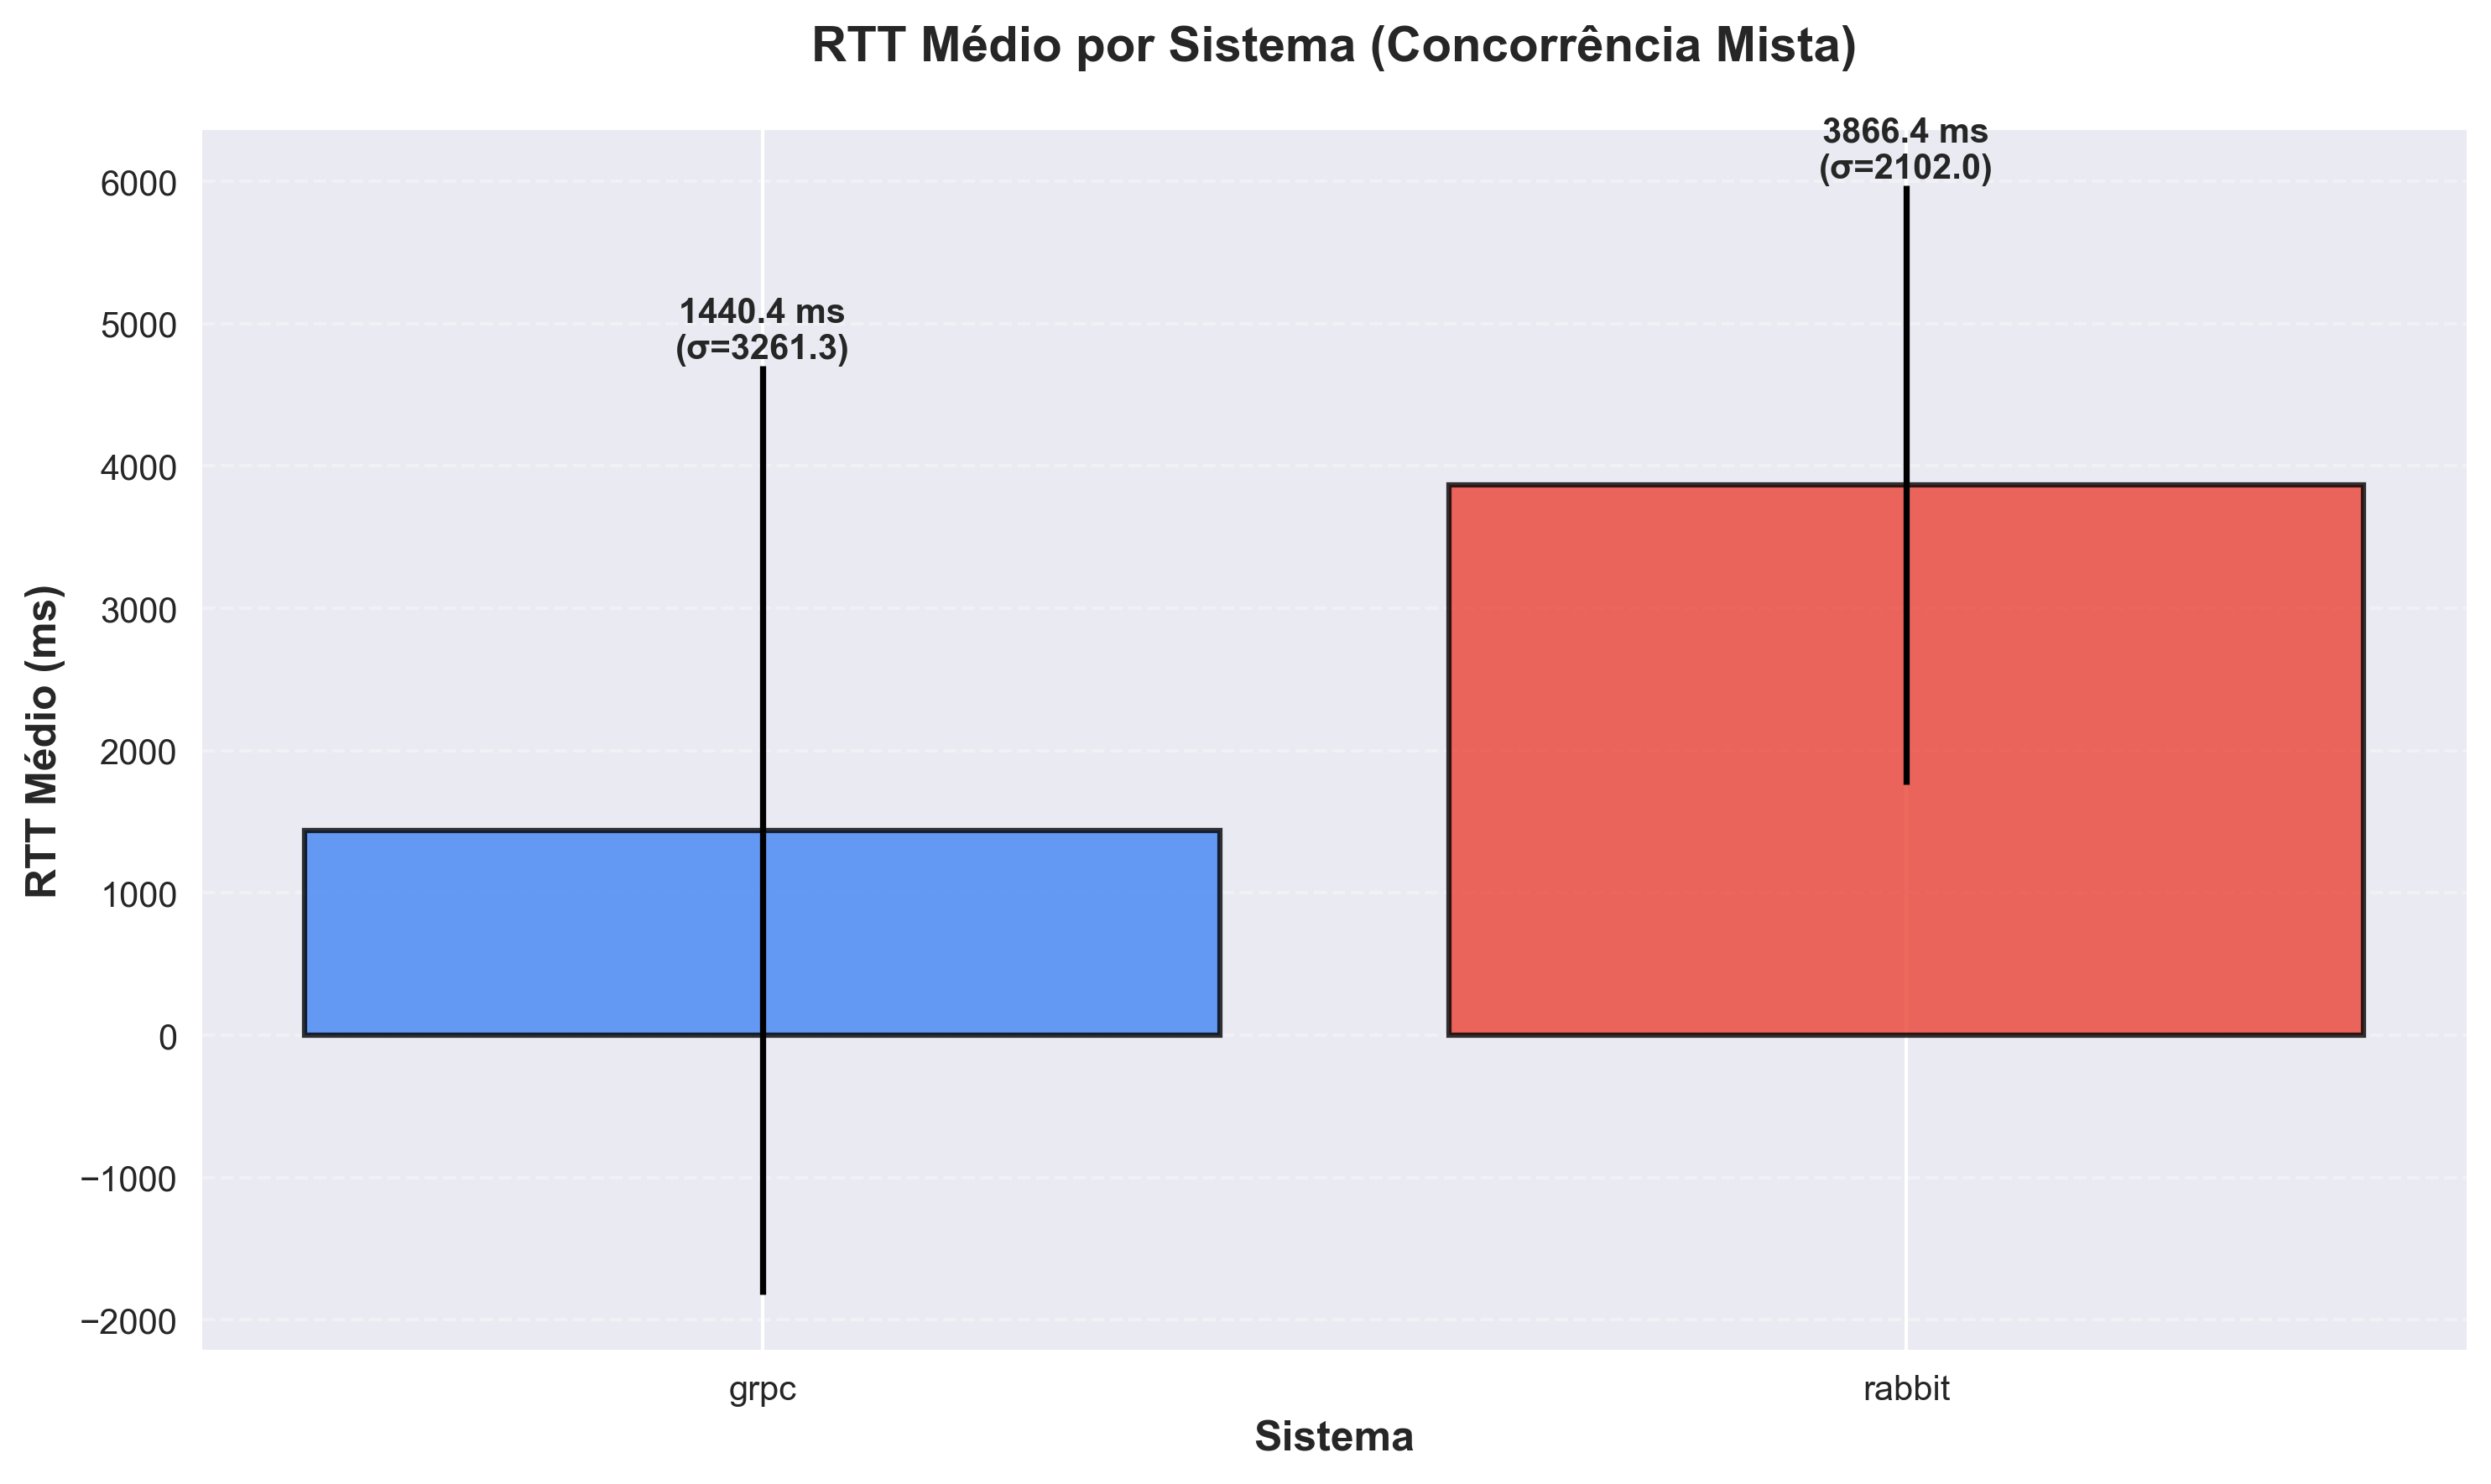

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

systems = df_success['system'].unique()
means = [df_success[df_success['system'] == s]['rtt_ms'].mean() for s in systems]
stds = [df_success[df_success['system'] == s]['rtt_ms'].std() for s in systems]

colors = [GRPC_COLOR if s == 'grpc' else RABBIT_COLOR for s in systems]
bars = ax.bar(systems, means, yerr=stds, capsize=5, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('RTT Médio (ms)', fontweight='bold')
ax.set_xlabel('Sistema', fontweight='bold')
ax.set_title('RTT Médio por Sistema (Concorrência Mista)', fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adiciona valores nas barras
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std,
            f'{mean:.1f} ms\n(σ={std:.1f})',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_rtt_by_system.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 2: RTT Médio por Operação


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_by_operation.png


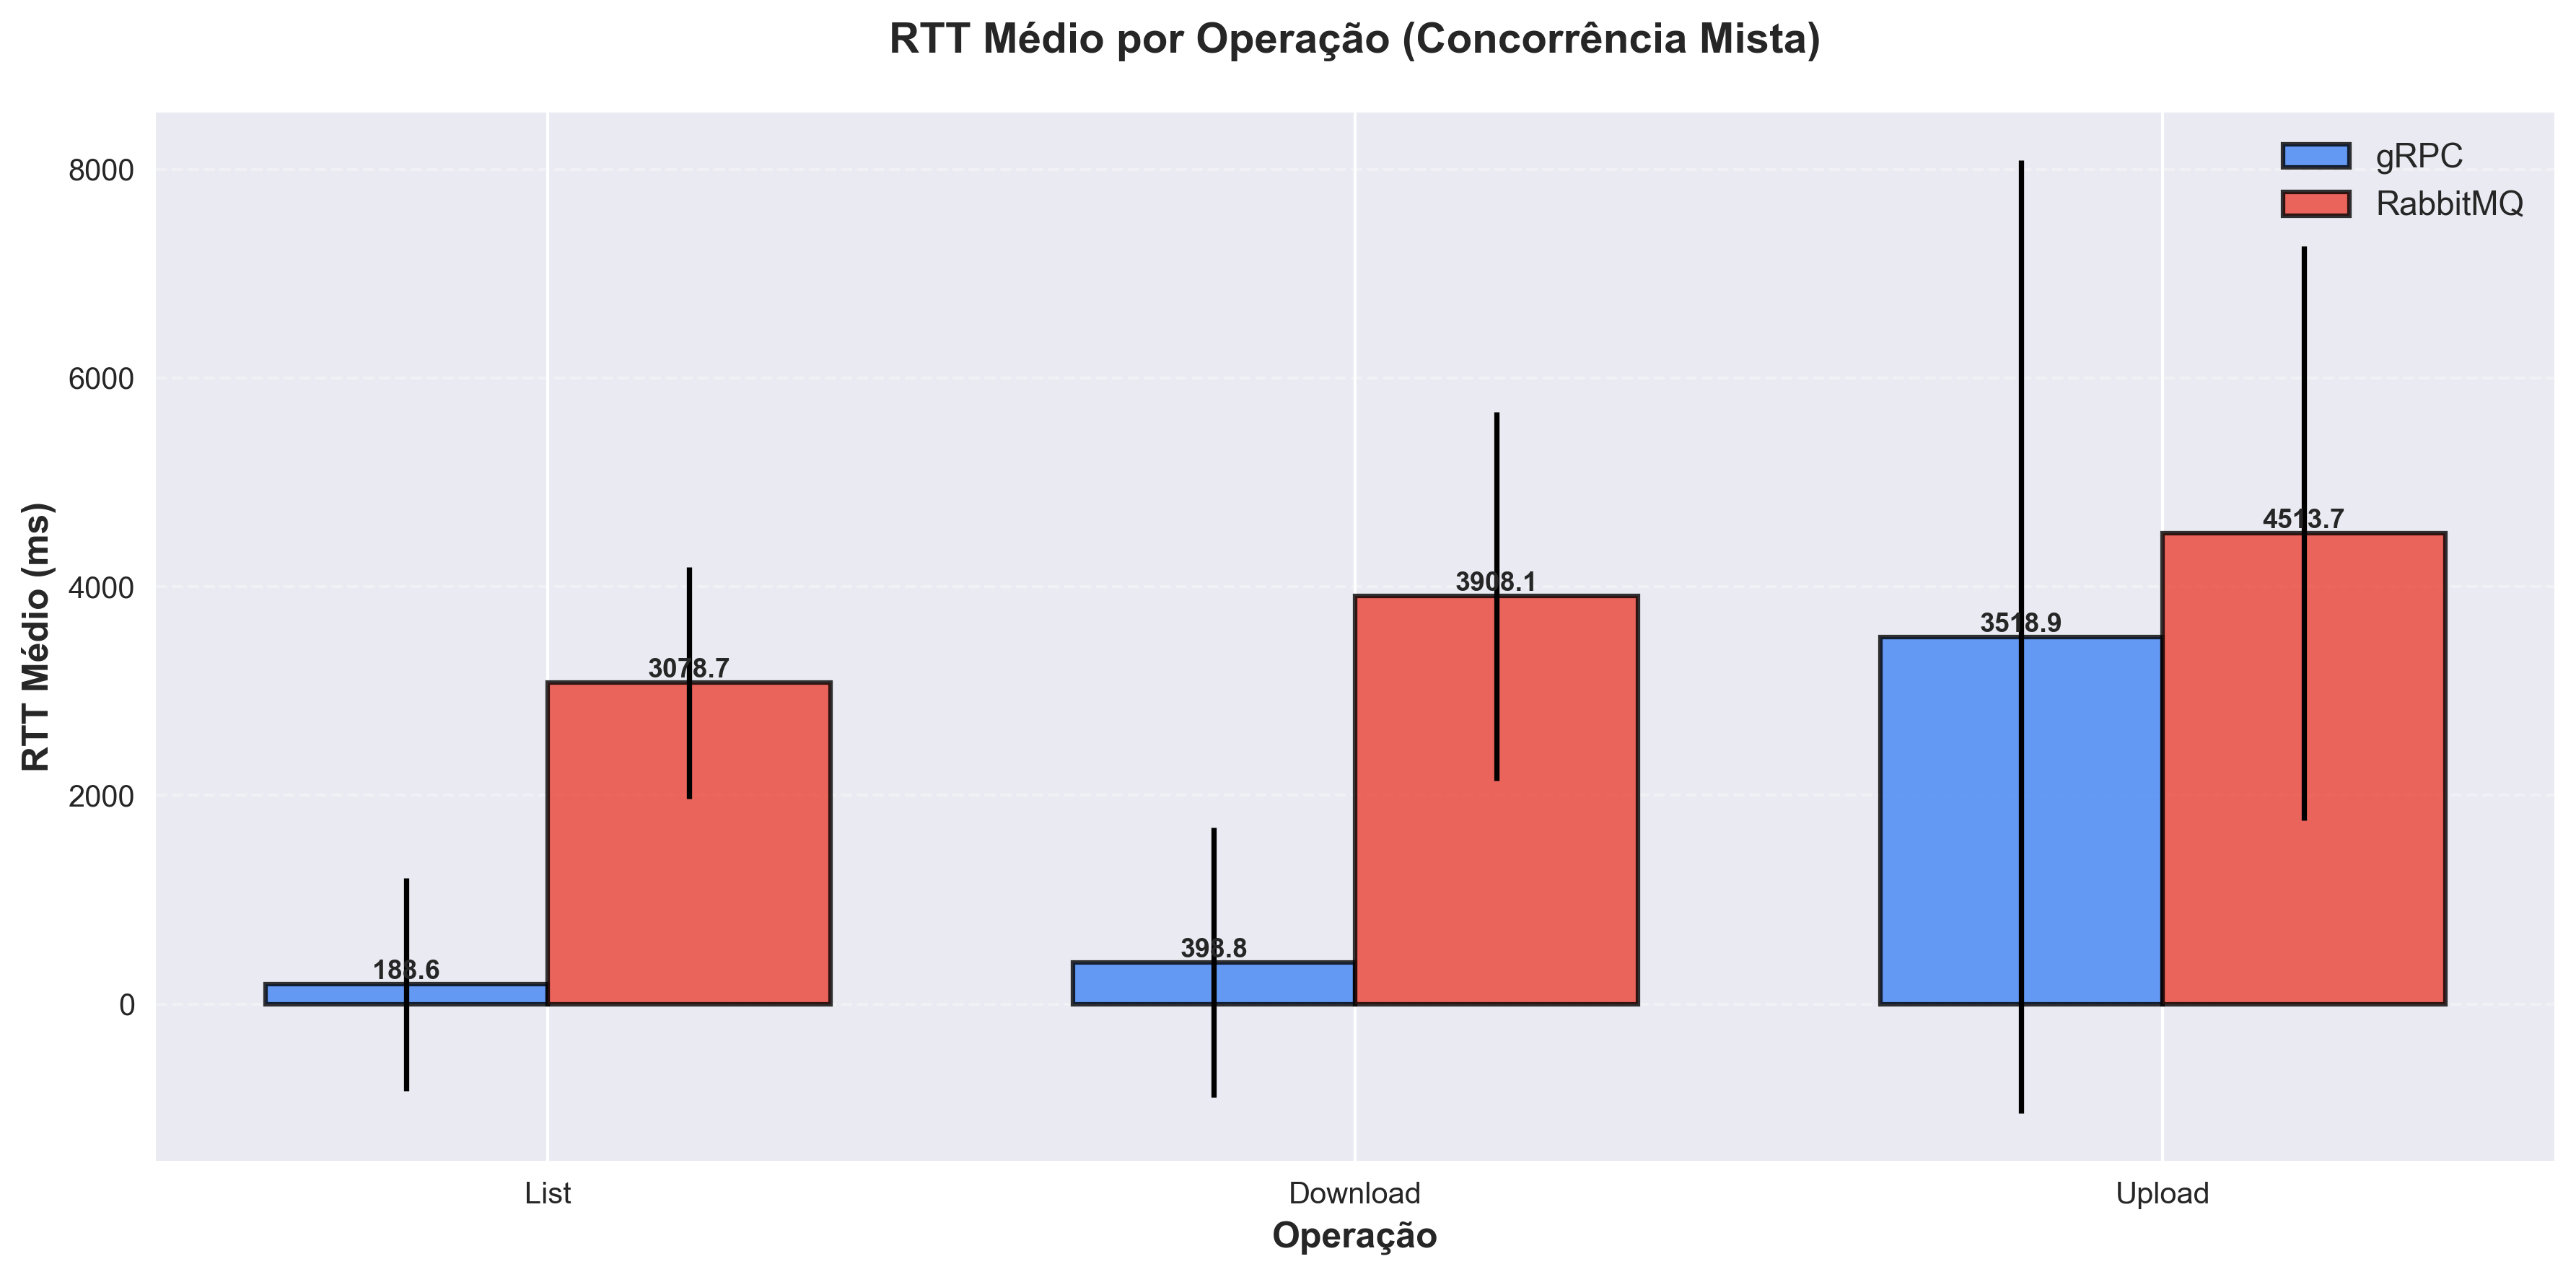

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

operations = df_success['operation'].unique()
x = np.arange(len(operations))
width = 0.35

grpc_means = []
rabbit_means = []
grpc_stds = []
rabbit_stds = []

for op in operations:
    grpc_data = df_success[(df_success['system'] == 'grpc') & (df_success['operation'] == op)]['rtt_ms']
    rabbit_data = df_success[(df_success['system'] == 'rabbit') & (df_success['operation'] == op)]['rtt_ms']
    
    if len(grpc_data) > 0:
        grpc_means.append(grpc_data.mean())
        grpc_stds.append(grpc_data.std())
    else:
        grpc_means.append(0)
        grpc_stds.append(0)
    
    if len(rabbit_data) > 0:
        rabbit_means.append(rabbit_data.mean())
        rabbit_stds.append(rabbit_data.std())
    else:
        rabbit_means.append(0)
        rabbit_stds.append(0)

bars1 = ax.bar(x - width/2, grpc_means, width, yerr=grpc_stds, label='gRPC', 
               color=GRPC_COLOR, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, rabbit_means, width, yerr=rabbit_stds, label='RabbitMQ', 
               color=RABBIT_COLOR, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)

ax.set_ylabel('RTT Médio (ms)', fontweight='bold')
ax.set_xlabel('Operação', fontweight='bold')
ax.set_title('RTT Médio por Operação (Concorrência Mista)', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([op.capitalize() for op in operations])
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adiciona valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_rtt_by_operation.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 3: RTT Médio por Tamanho de Arquivo


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_by_file_size.png


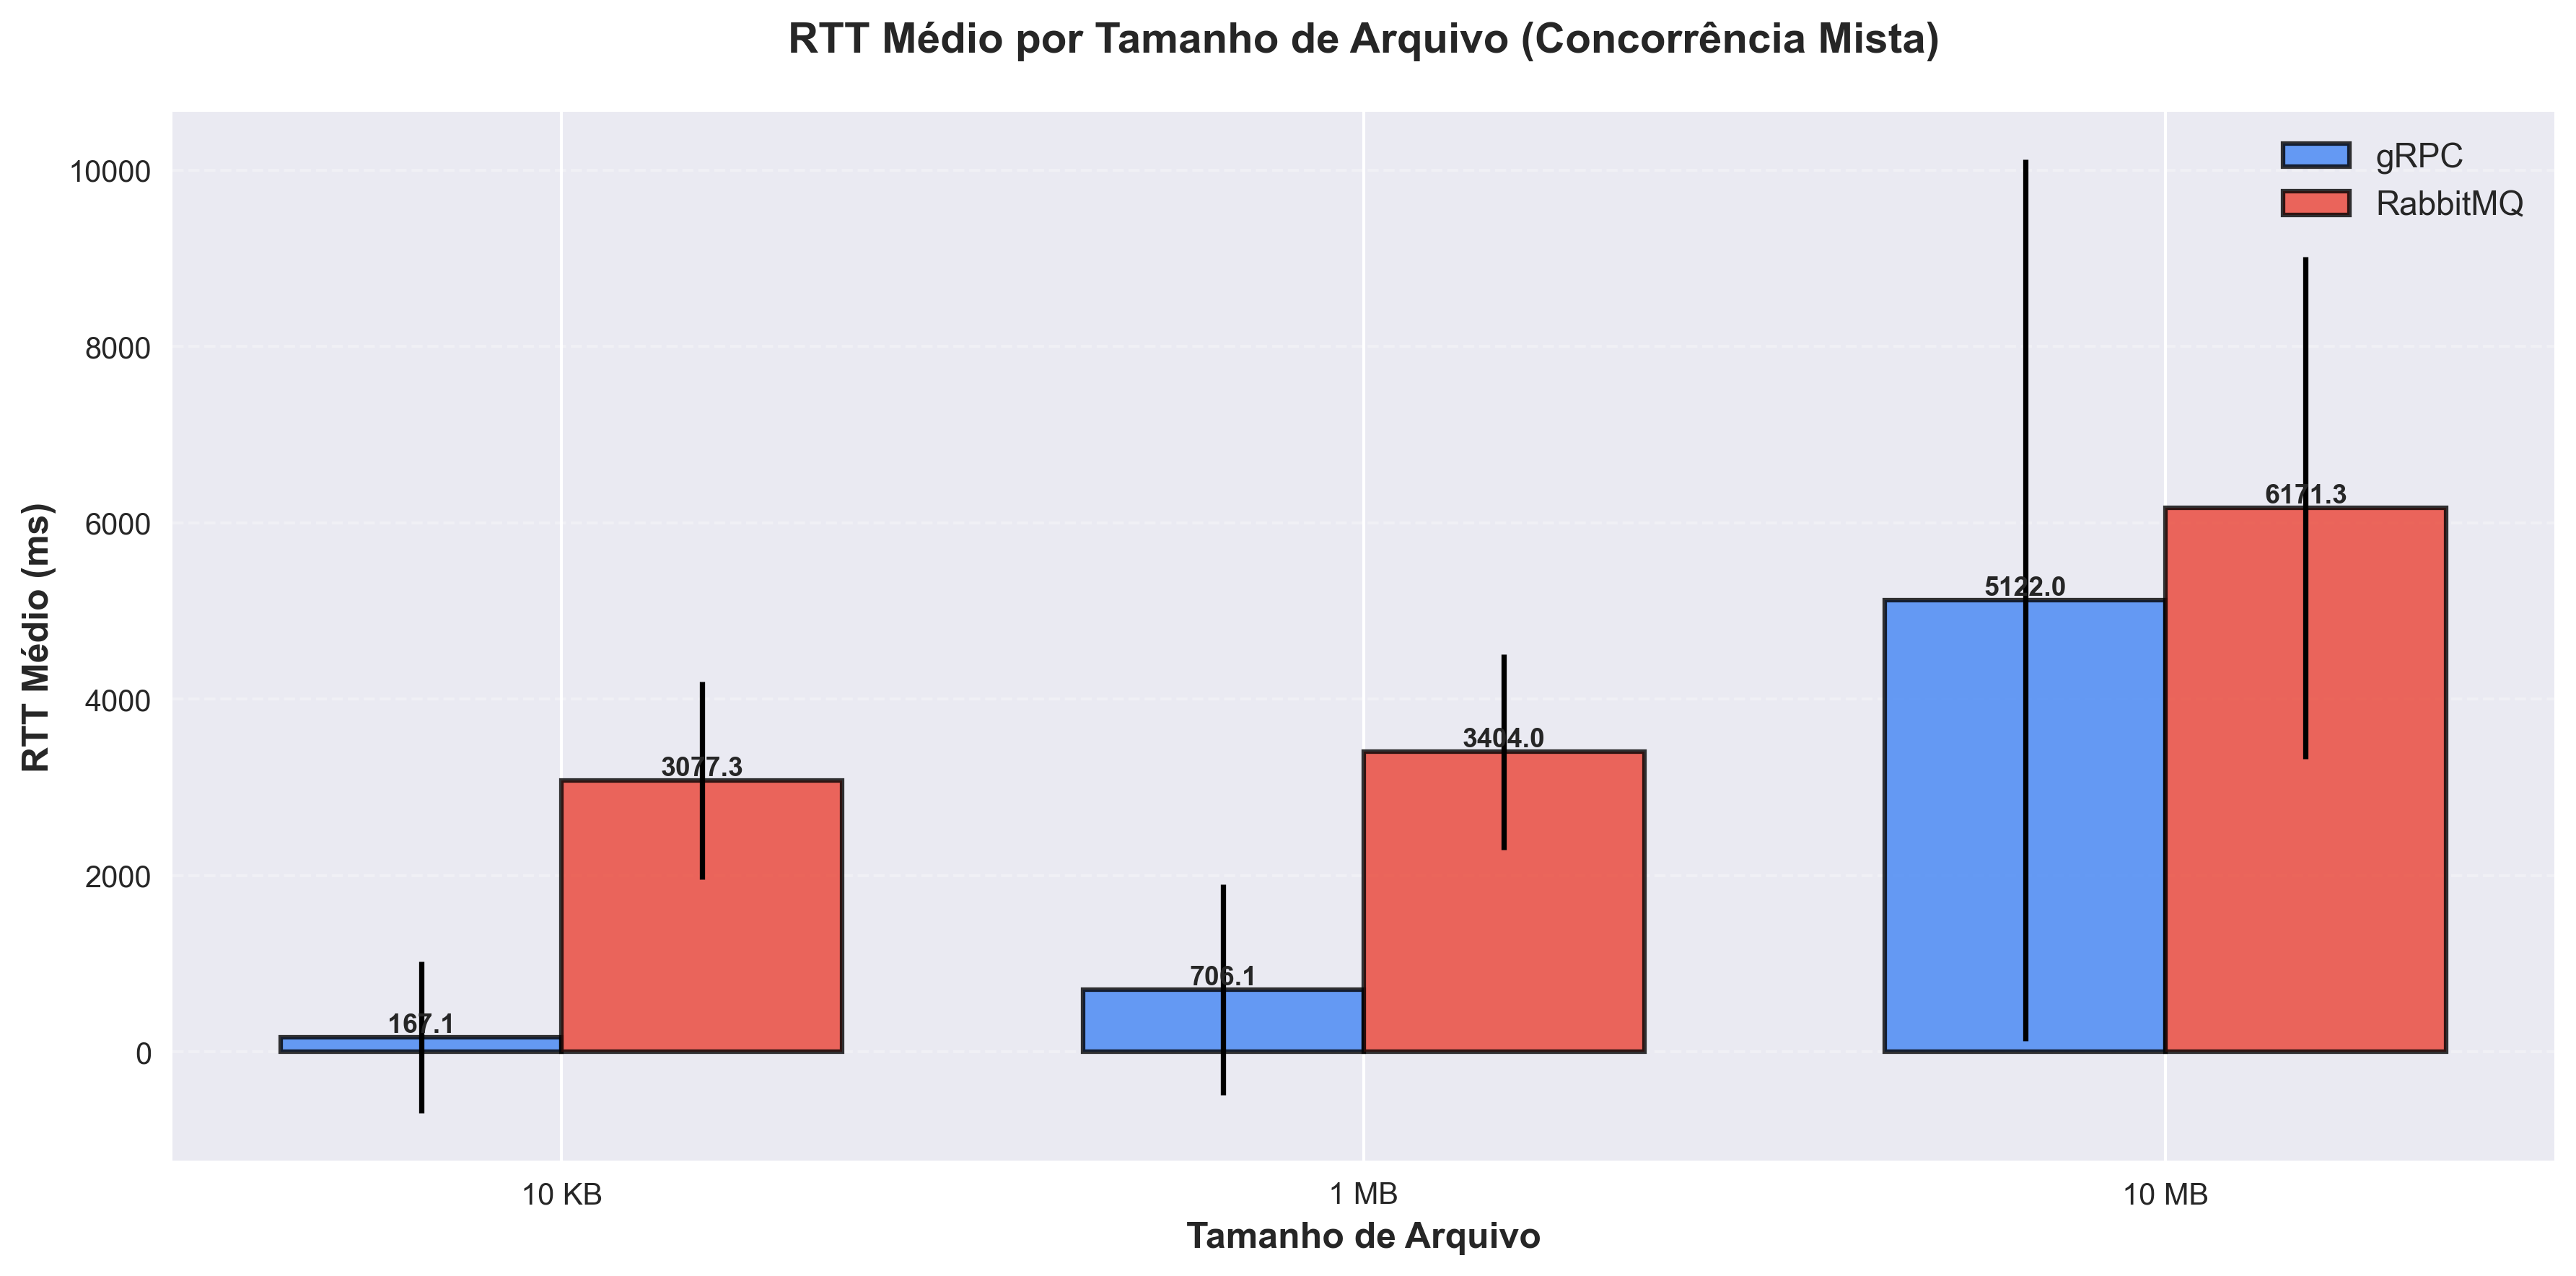

In [9]:
# Filtra apenas upload e download (list não tem tamanho)
df_with_size = df_success[df_success['file_size_kb'] > 0].copy()

if len(df_with_size) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))

    sizes = sorted(df_with_size['file_size_kb'].unique())
    size_labels = [format_file_size(s) for s in sizes]
    x = np.arange(len(sizes))
    width = 0.35

    grpc_means = []
    rabbit_means = []
    grpc_stds = []
    rabbit_stds = []

    for size in sizes:
        grpc_data = df_with_size[(df_with_size['system'] == 'grpc') & (df_with_size['file_size_kb'] == size)]['rtt_ms']
        rabbit_data = df_with_size[(df_with_size['system'] == 'rabbit') & (df_with_size['file_size_kb'] == size)]['rtt_ms']
        
        if len(grpc_data) > 0:
            grpc_means.append(grpc_data.mean())
            grpc_stds.append(grpc_data.std())
        else:
            grpc_means.append(0)
            grpc_stds.append(0)
        
        if len(rabbit_data) > 0:
            rabbit_means.append(rabbit_data.mean())
            rabbit_stds.append(rabbit_data.std())
        else:
            rabbit_means.append(0)
            rabbit_stds.append(0)

    bars1 = ax.bar(x - width/2, grpc_means, width, yerr=grpc_stds, label='gRPC', 
                   color=GRPC_COLOR, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, rabbit_means, width, yerr=rabbit_stds, label='RabbitMQ', 
                   color=RABBIT_COLOR, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)

    ax.set_ylabel('RTT Médio (ms)', fontweight='bold')
    ax.set_xlabel('Tamanho de Arquivo', fontweight='bold')
    ax.set_title('RTT Médio por Tamanho de Arquivo (Concorrência Mista)', fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(size_labels)
    ax.legend(fontsize=11, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Adiciona valores
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    output_file = output_dir / 'mixed_concurrency_rtt_by_file_size.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Gráfico salvo: {output_file}")
    plt.show()
else:
    print("⚠️  Nenhum dado com tamanho de arquivo disponível")


## Gráfico 4: Distribuição de RTT (Histograma)


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_distribution.png


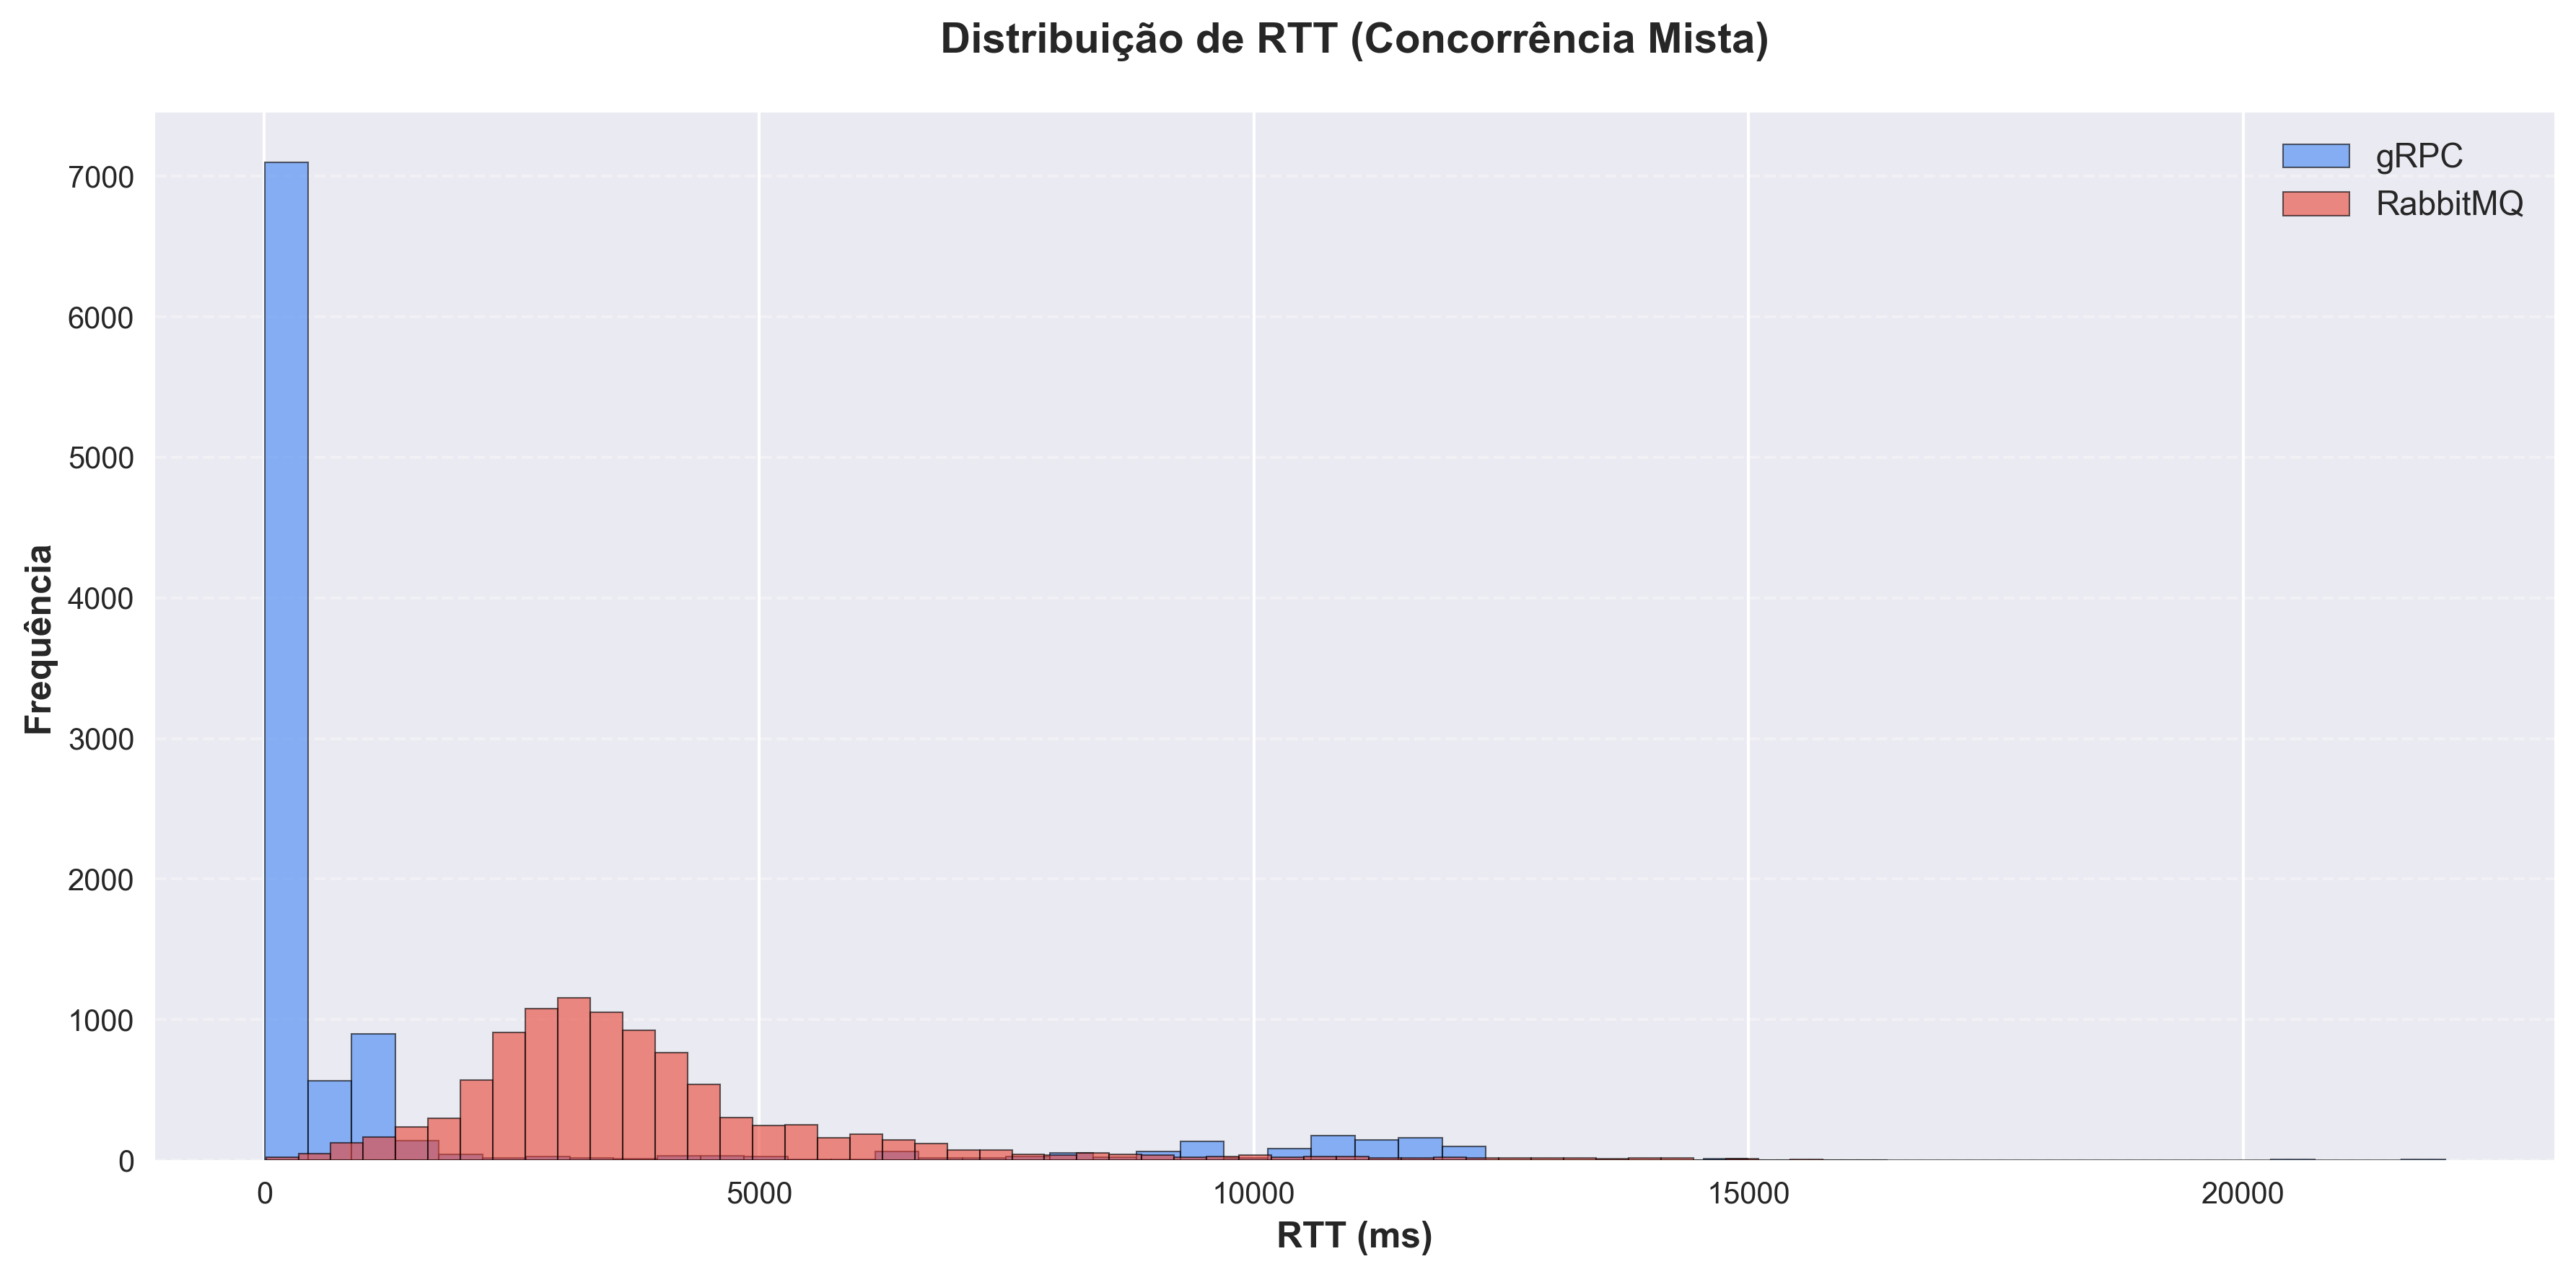

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

for system in df_success['system'].unique():
    data = df_success[df_success['system'] == system]['rtt_ms']
    color = GRPC_COLOR if system == 'grpc' else RABBIT_COLOR
    label = 'gRPC' if system == 'grpc' else 'RabbitMQ'
    
    ax.hist(data, bins=50, alpha=0.6, label=label, color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('RTT (ms)', fontweight='bold')
ax.set_ylabel('Frequência', fontweight='bold')
ax.set_title('Distribuição de RTT (Concorrência Mista)', fontweight='bold', pad=20)
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_rtt_distribution.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 5: Percentis de RTT (Box Plot)


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_boxplot.png


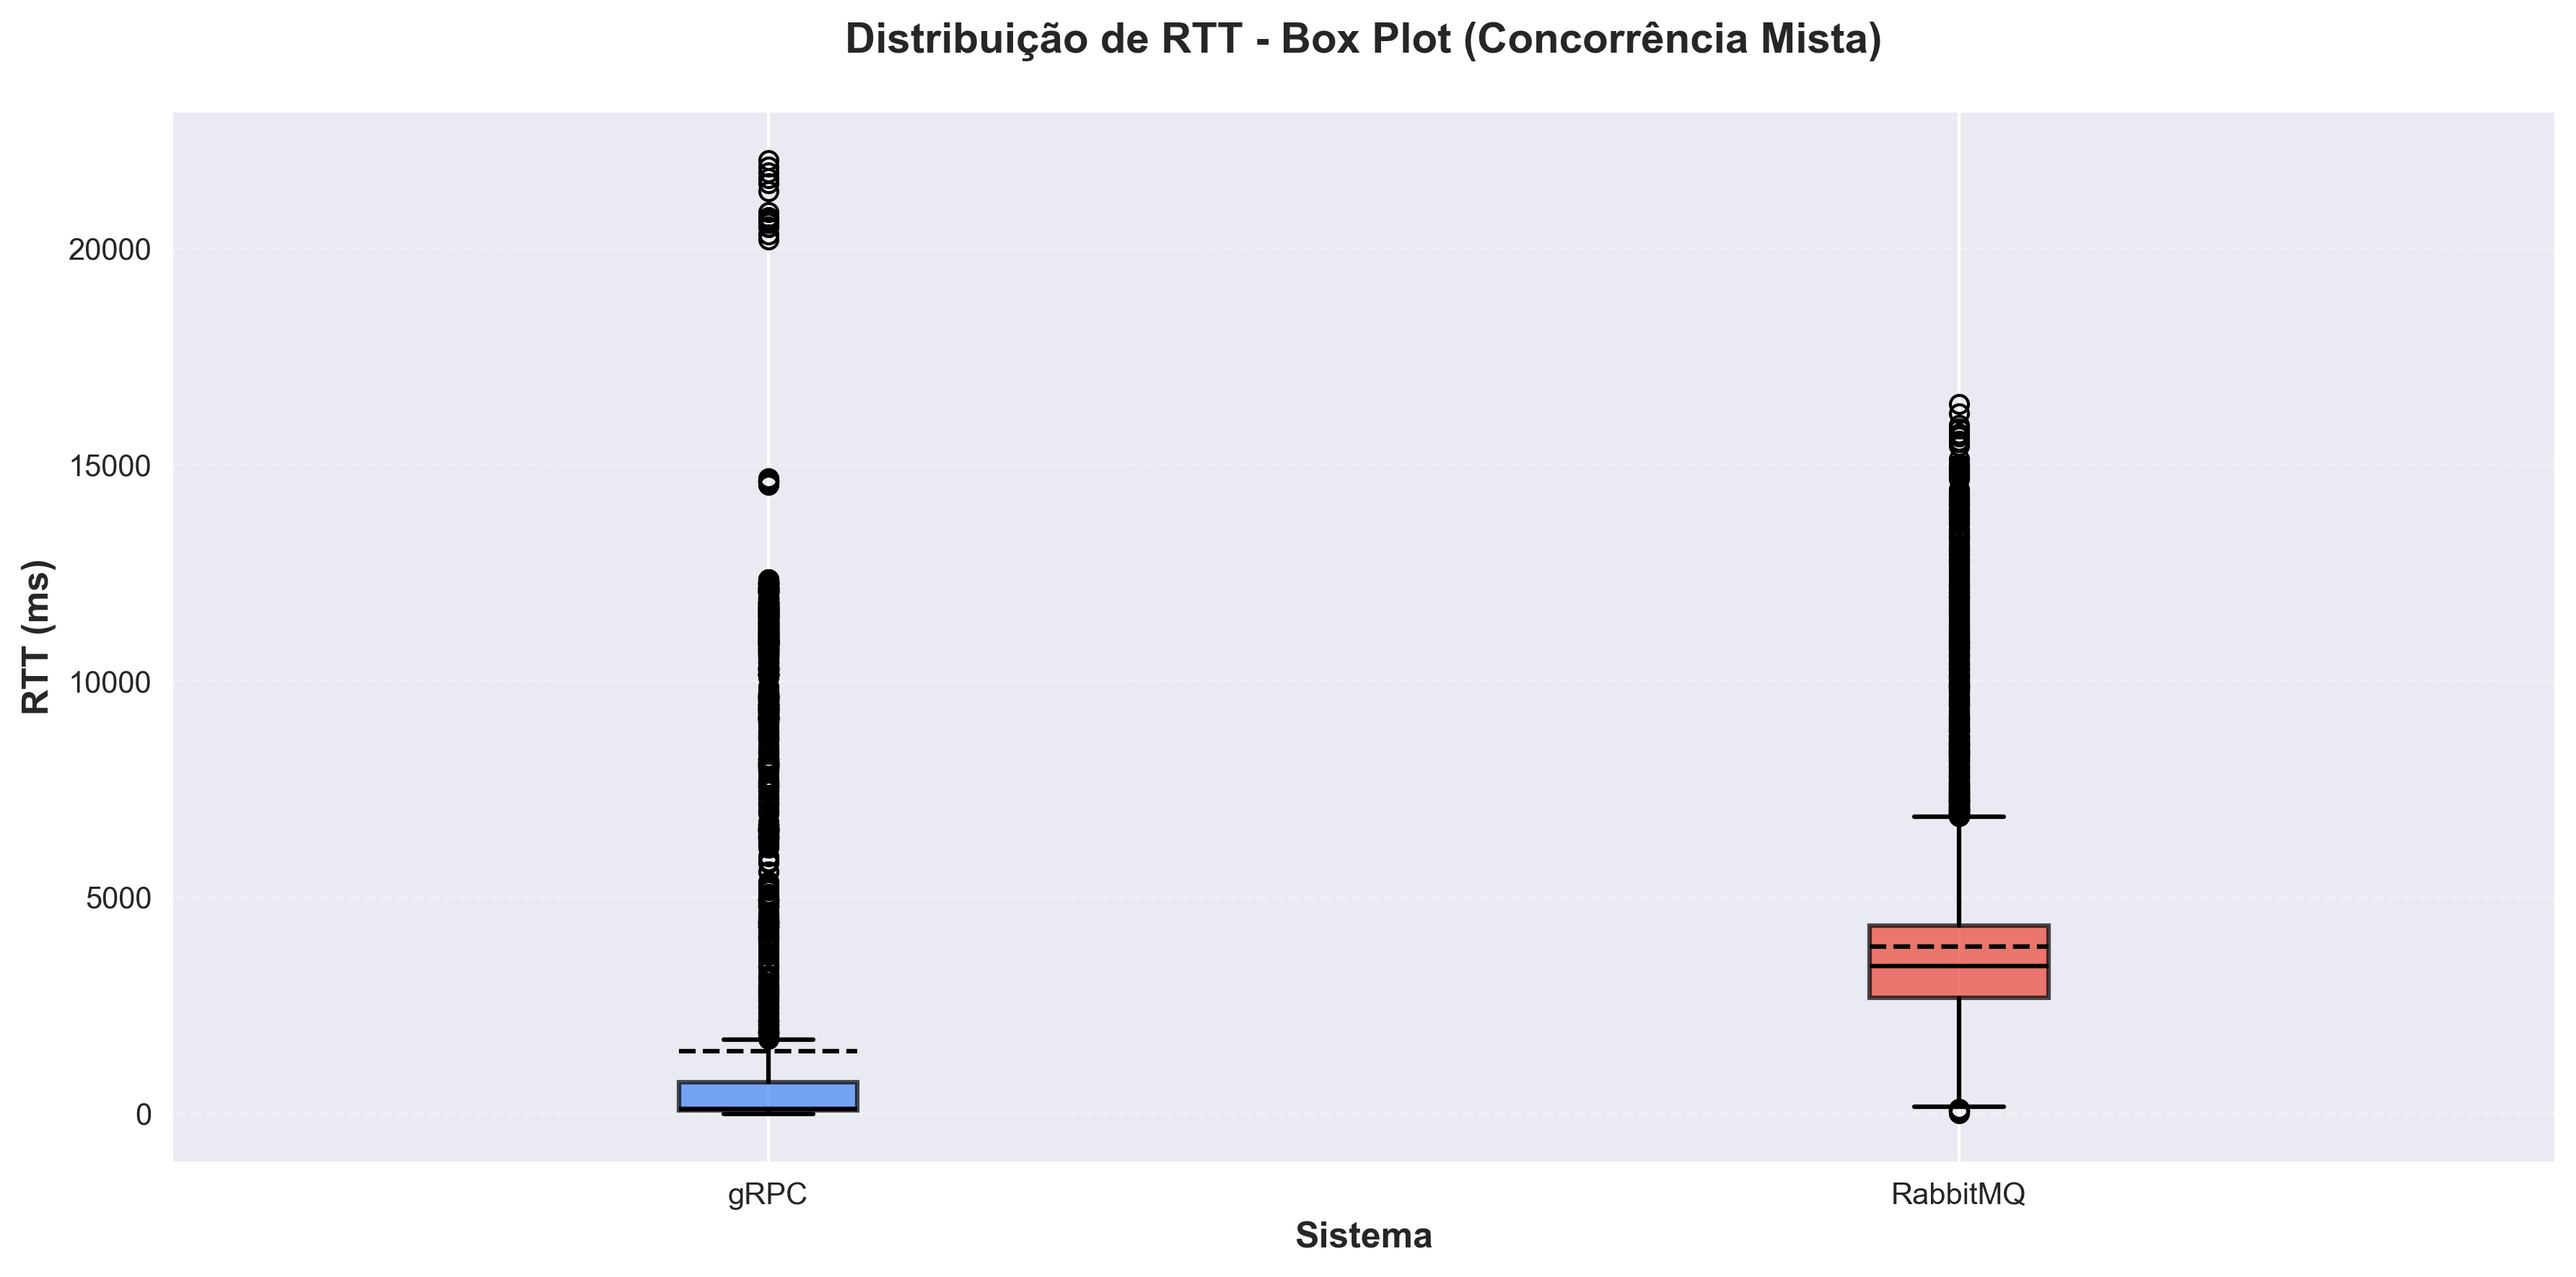

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

data_for_box = []
labels = []
colors_box = []

for system in df_success['system'].unique():
    data = df_success[df_success['system'] == system]['rtt_ms']
    data_for_box.append(data)
    label = 'gRPC' if system == 'grpc' else 'RabbitMQ'
    labels.append(label)
    colors_box.append(GRPC_COLOR if system == 'grpc' else RABBIT_COLOR)

bp = ax.boxplot(data_for_box, labels=labels, patch_artist=True, 
                showmeans=True, meanline=True)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    for item in bp[element]:
        item.set_color('black')
        item.set_linewidth(1.5)

ax.set_ylabel('RTT (ms)', fontweight='bold')
ax.set_xlabel('Sistema', fontweight='bold')
ax.set_title('Distribuição de RTT - Box Plot (Concorrência Mista)', fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_rtt_boxplot.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 6: Taxa de Sucesso


✅ Gráfico salvo: ../results/plots/mixed_concurrency_success_rate.png


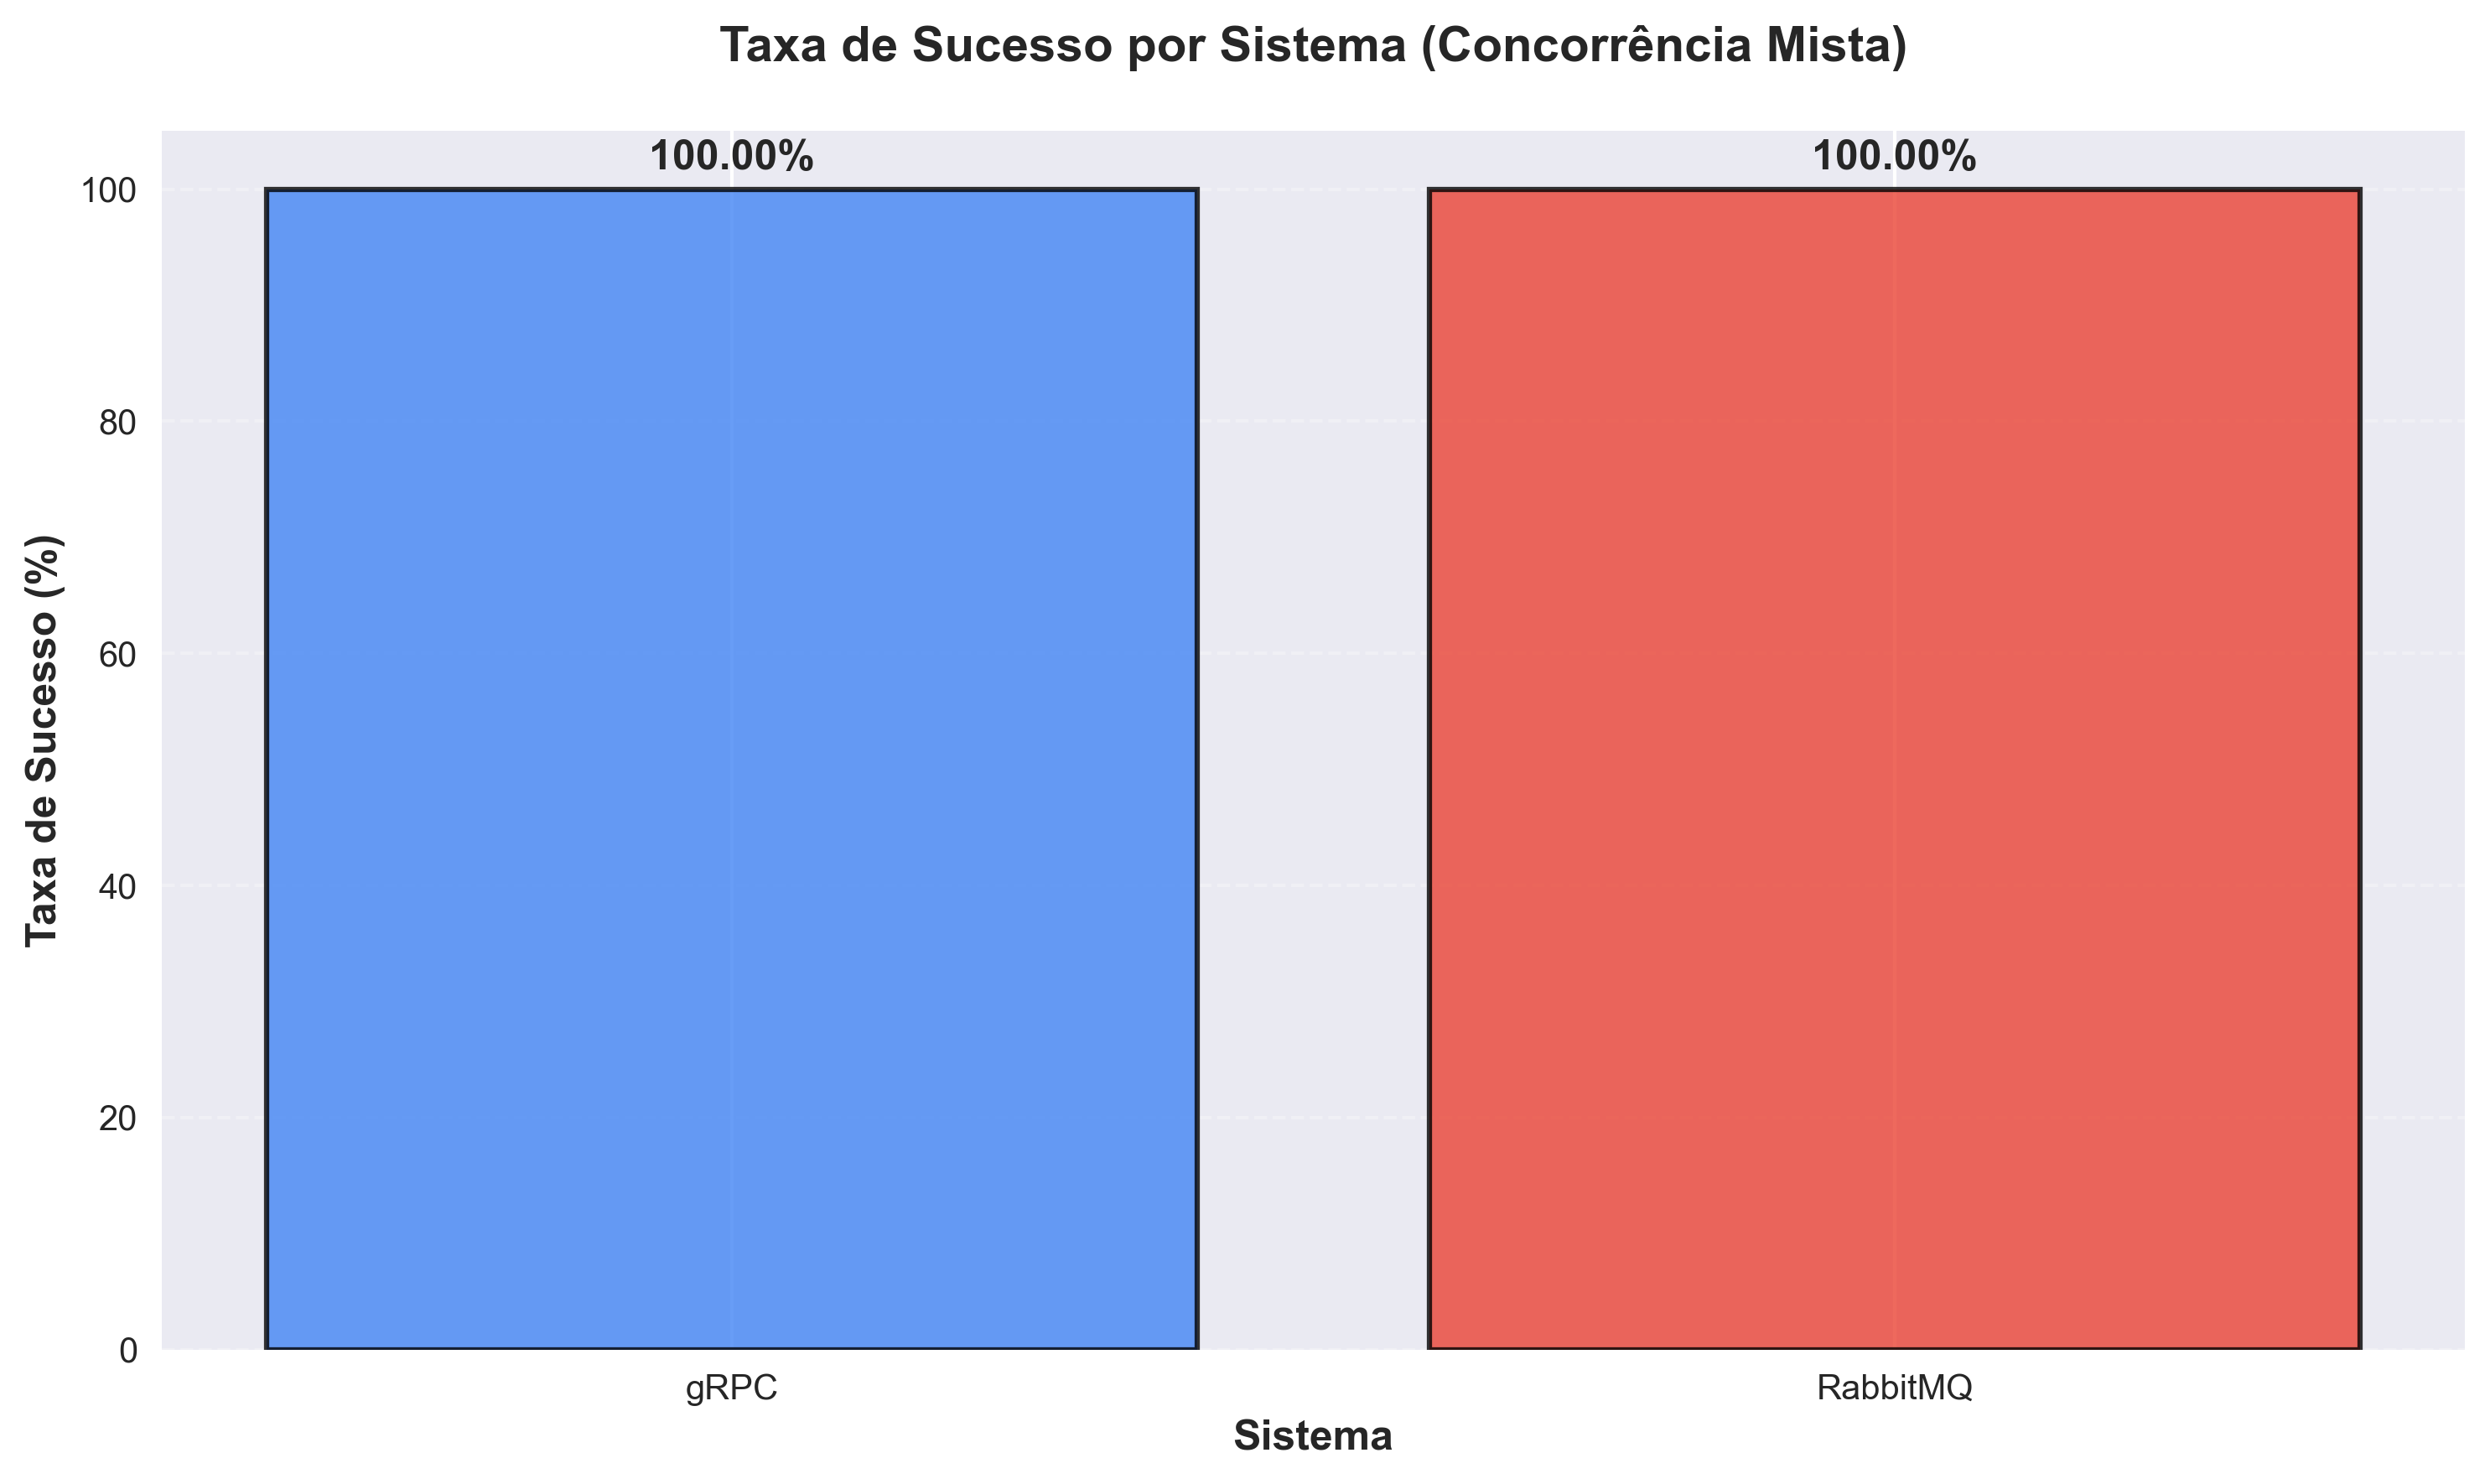

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

success_rates = []
systems = []
colors_bar = []

for system in df['system'].unique():
    system_data = df[df['system'] == system]
    success_count = len(system_data[system_data['success'] == True])
    total_count = len(system_data)
    success_rate = (success_count / total_count * 100) if total_count > 0 else 0
    
    success_rates.append(success_rate)
    systems.append('gRPC' if system == 'grpc' else 'RabbitMQ')
    colors_bar.append(GRPC_COLOR if system == 'grpc' else RABBIT_COLOR)

bars = ax.bar(systems, success_rates, color=colors_bar, alpha=0.8, 
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Taxa de Sucesso (%)', fontweight='bold')
ax.set_xlabel('Sistema', fontweight='bold')
ax.set_title('Taxa de Sucesso por Sistema (Concorrência Mista)', fontweight='bold', pad=20)
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adiciona valores
for bar, rate in zip(bars, success_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_success_rate.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 7: RTT ao Longo do Tempo


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_over_time.png


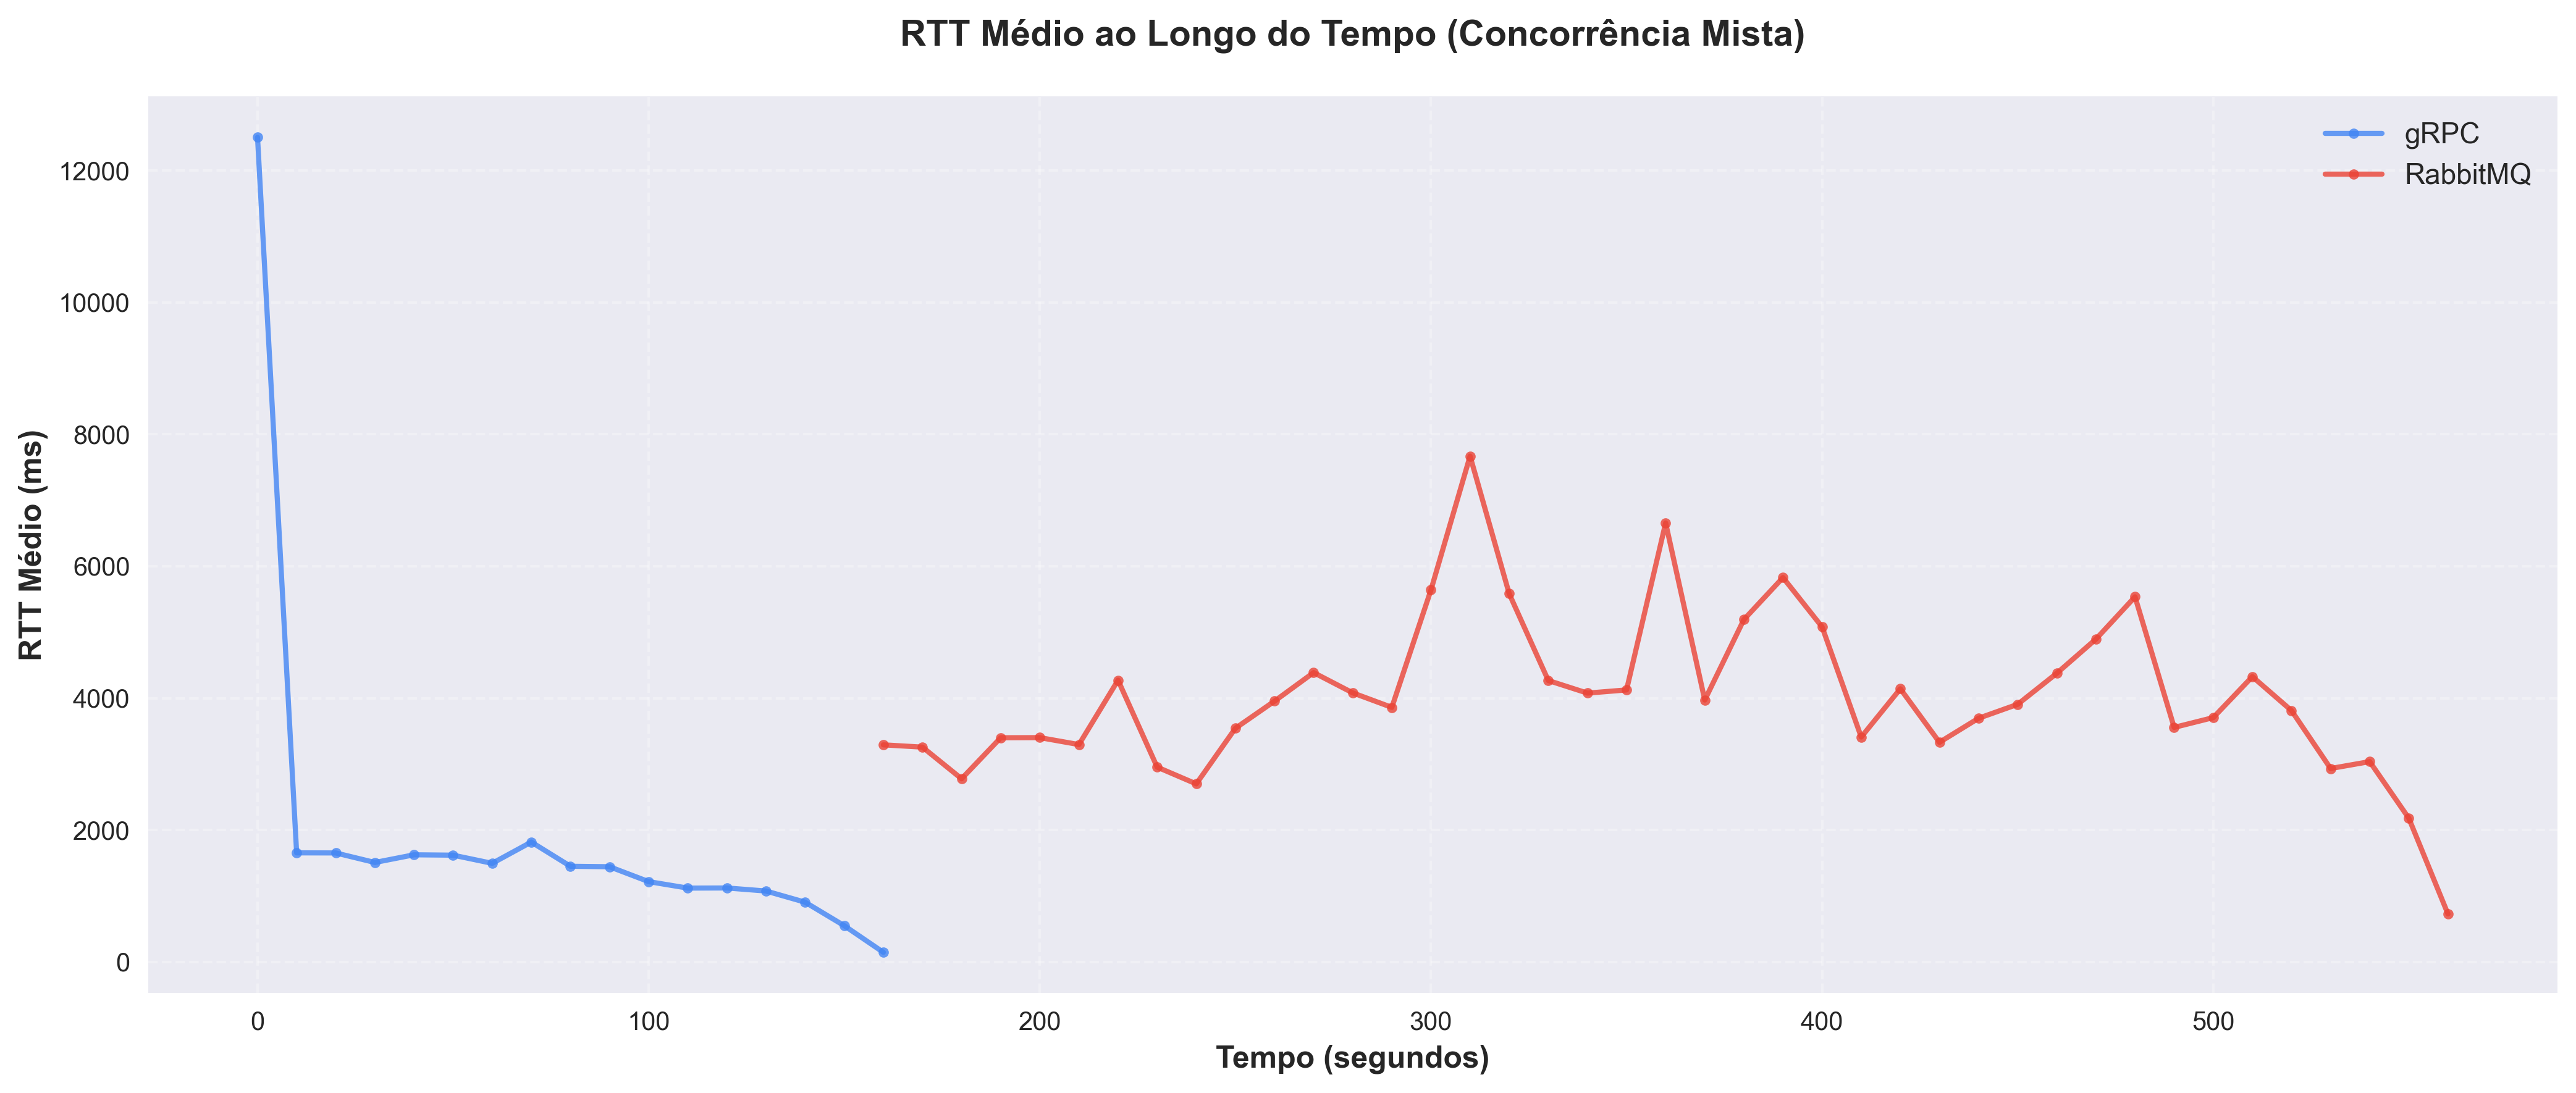

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))

# Agrupa por intervalo de tempo (ex: a cada 10 segundos)
df_success['time_bin'] = (df_success['timestamp'] - df_success['timestamp'].min()).dt.total_seconds() // 10

for system in df_success['system'].unique():
    system_data = df_success[df_success['system'] == system]
    time_means = system_data.groupby('time_bin')['rtt_ms'].mean()
    
    color = GRPC_COLOR if system == 'grpc' else RABBIT_COLOR
    label = 'gRPC' if system == 'grpc' else 'RabbitMQ'
    
    ax.plot(time_means.index * 10, time_means.values, marker='o', label=label, 
            color=color, linewidth=2, markersize=4, alpha=0.8)

ax.set_xlabel('Tempo (segundos)', fontweight='bold')
ax.set_ylabel('RTT Médio (ms)', fontweight='bold')
ax.set_title('RTT Médio ao Longo do Tempo (Concorrência Mista)', fontweight='bold', pad=20)
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_rtt_over_time.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 3: Distribuição de RTT (Histograma)


✅ Gráfico salvo: ../results/plots/mixed_concurrency_rtt_distribution.png


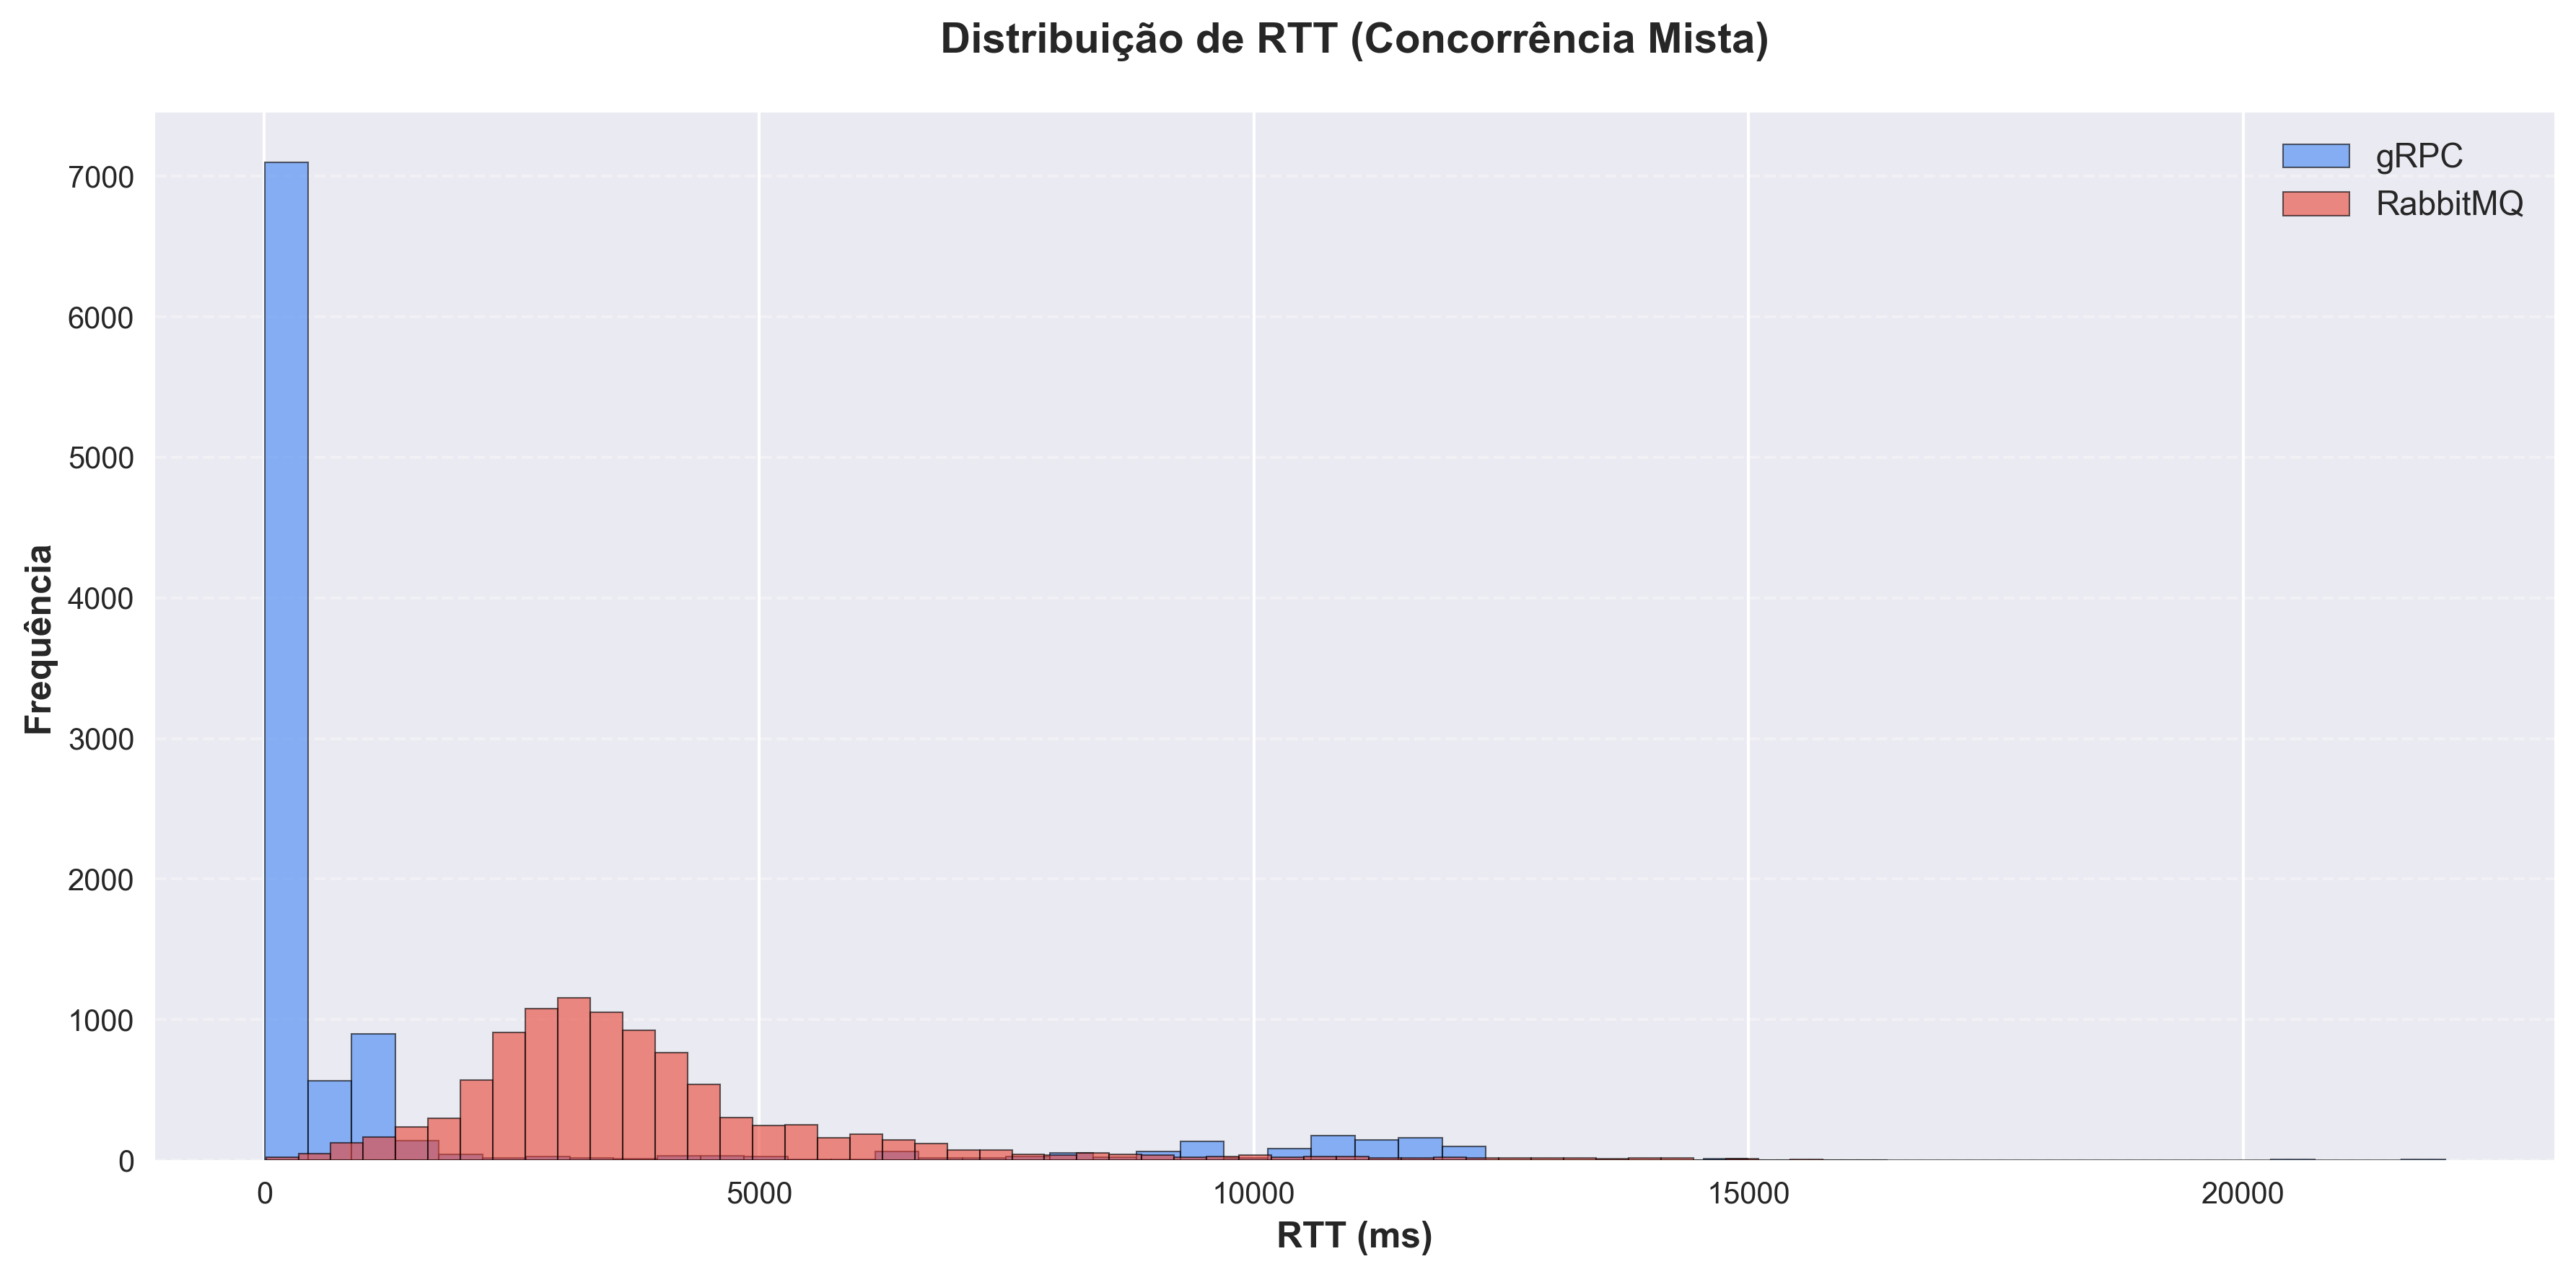

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

for system in df_success['system'].unique():
    data = df_success[df_success['system'] == system]['rtt_ms']
    color = GRPC_COLOR if system == 'grpc' else RABBIT_COLOR
    label = 'gRPC' if system == 'grpc' else 'RabbitMQ'
    
    ax.hist(data, bins=50, alpha=0.6, label=label, color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('RTT (ms)', fontweight='bold')
ax.set_ylabel('Frequência', fontweight='bold')
ax.set_title('Distribuição de RTT (Concorrência Mista)', fontweight='bold', pad=20)
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_rtt_distribution.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Gráfico 4: Taxa de Sucesso


✅ Gráfico salvo: ../results/plots/mixed_concurrency_success_rate.png


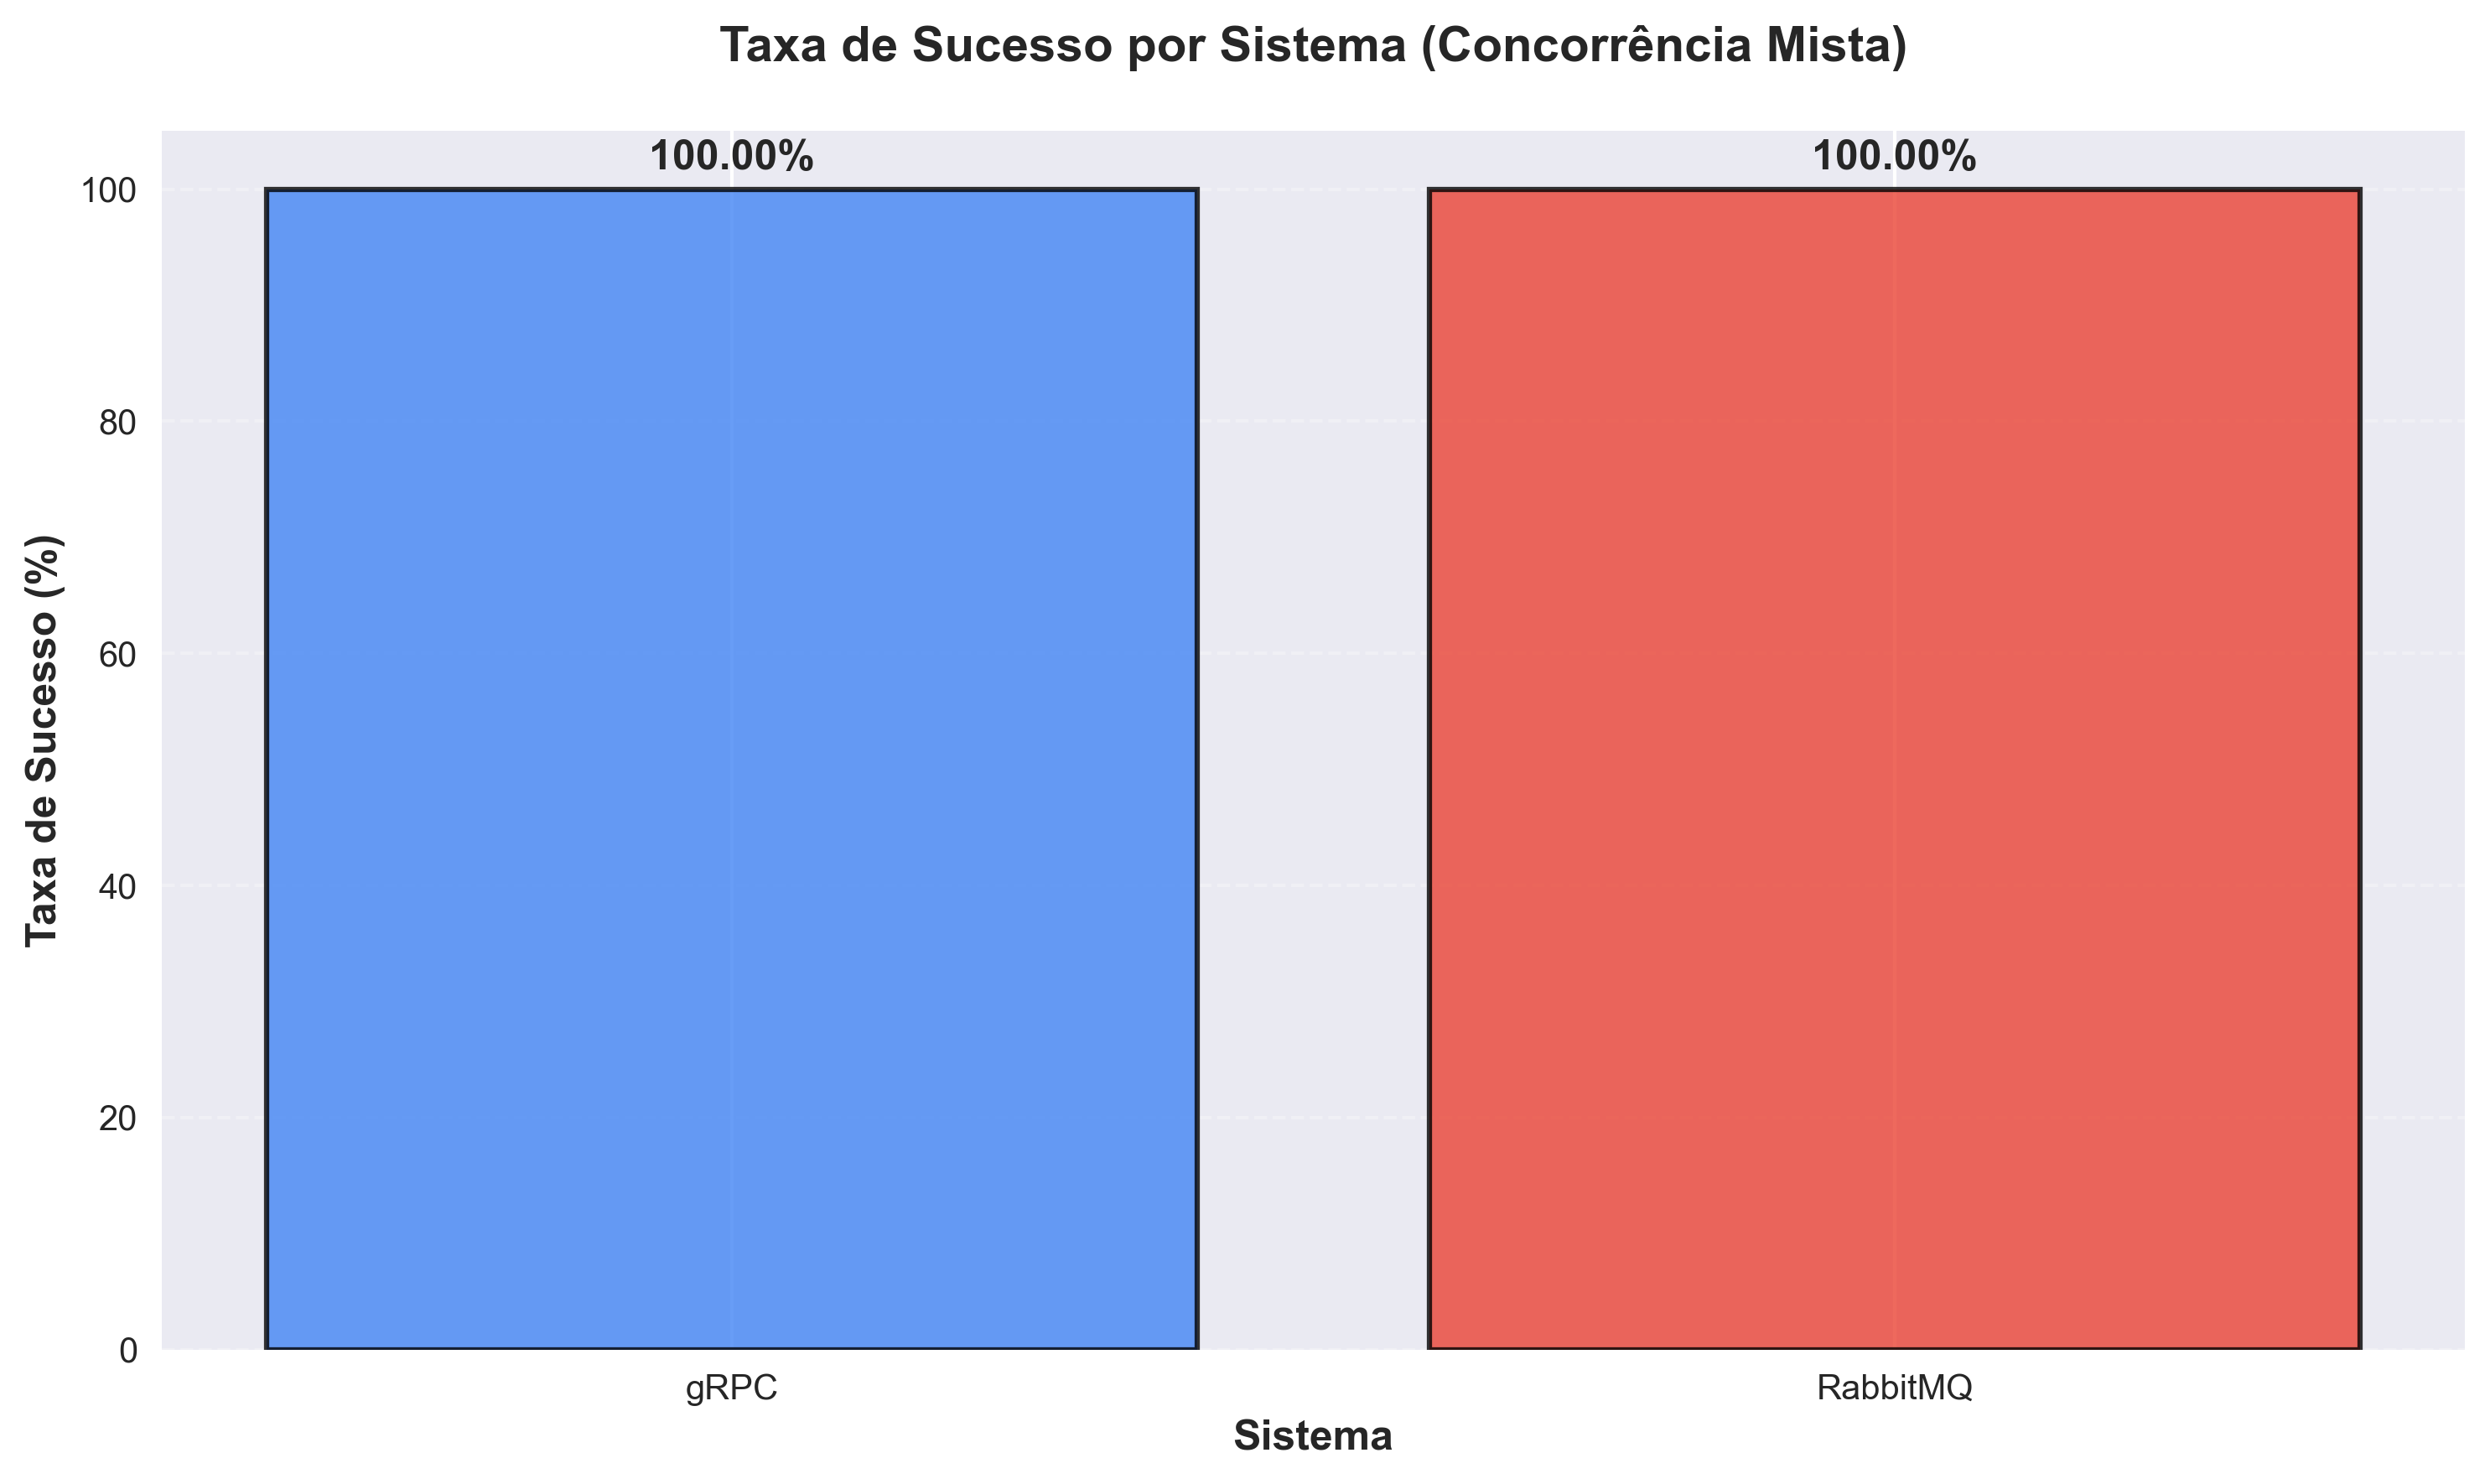

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

success_rates = []
systems = []
colors_bar = []

for system in df['system'].unique():
    system_data = df[df['system'] == system]
    success_count = len(system_data[system_data['success'] == True])
    total_count = len(system_data)
    success_rate = (success_count / total_count * 100) if total_count > 0 else 0
    
    success_rates.append(success_rate)
    systems.append('gRPC' if system == 'grpc' else 'RabbitMQ')
    colors_bar.append(GRPC_COLOR if system == 'grpc' else RABBIT_COLOR)

bars = ax.bar(systems, success_rates, color=colors_bar, alpha=0.8, 
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Taxa de Sucesso (%)', fontweight='bold')
ax.set_xlabel('Sistema', fontweight='bold')
ax.set_title('Taxa de Sucesso por Sistema (Concorrência Mista)', fontweight='bold', pad=20)
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adiciona valores
for bar, rate in zip(bars, success_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
output_file = output_dir / 'mixed_concurrency_success_rate.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo: {output_file}")
plt.show()


## Resumo Final


In [16]:
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("  Resumo da Análise de Concorrência Mista")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print()

for system in df_success['system'].unique():
    system_data = df_success[df_success['system'] == system]
    system_name = 'gRPC' if system == 'grpc' else 'RabbitMQ'
    
    print(f"📊 {system_name}:")
    print(f"   Total de operações: {len(df[df['system'] == system])}")
    print(f"   Taxa de sucesso: {len(system_data)/len(df[df['system'] == system])*100:.2f}%")
    print(f"   RTT médio: {system_data['rtt_ms'].mean():.3f} ms")
    print(f"   RTT p50: {system_data['rtt_ms'].quantile(0.5):.3f} ms")
    print(f"   RTT p95: {system_data['rtt_ms'].quantile(0.95):.3f} ms")
    print(f"   RTT p99: {system_data['rtt_ms'].quantile(0.99):.3f} ms")
    print()

print(f"✅ Todos os gráficos foram salvos em: {output_dir.absolute()}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Resumo da Análise de Concorrência Mista
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 gRPC:
   Total de operações: 10000
   Taxa de sucesso: 100.00%
   RTT médio: 1440.427 ms
   RTT p50: 118.061 ms
   RTT p95: 10897.862 ms
   RTT p99: 12075.548 ms

📊 RabbitMQ:
   Total de operações: 10000
   Taxa de sucesso: 100.00%
   RTT médio: 3866.407 ms
   RTT p50: 3406.921 ms
   RTT p95: 7957.885 ms
   RTT p99: 12778.781 ms

✅ Todos os gráficos foram salvos em: /Users/ernesto/Desktop/grpc-rabbitmq-fileshare/scripts/../results/plots
